## The Task is to use machine learning to forecast gross enrollment in 2015-16, using data of 2012-15 session, such as dropout rate, water and computer facilities. 
## In this notebook the task was approached as a Regression problem.

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import Relevant Packages
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.impute import SimpleImputer 
# from sklearn.linear_model import LogisticRegression
# from sklearn.cluster import KMeans
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
# from sklearn.svm import SVC
# from catboost import CatBoostClassifier
# from sklearn.model_selection import StratifiedKFold, KFold
# from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, log_loss, f1_score, mean_squared_error,mean_absolute_error,r2_score
# from xgboost import XGBRegressor
# from sklearn.linear_model import Lasso,Ridge,ElasticNet

In [3]:
sm, md, lg = 13, 15, 20 
plt.rc('font', size=sm)
plt.rc('axes', labelsize=sm)
plt.rc('xtick', labelsize=md)
plt.rc('ytick', labelsize=md)
plt.rc('legend', fontsize=md)
plt.rc('figure', titlesize=lg)

In [1]:
root = '../Data/'

In [3]:
drop_out = pd.read_csv(root+'dropout-ratio-2012-2015.csv')
enrol = pd.read_csv(root+'gross-enrollment-ratio-2013-2016.csv')
comp = pd.read_csv(root+'percentage-of-schools-with-comps-2013-2016.csv')
elect = pd.read_csv(root+'percentage-of-schools-with-electricity-2013-2016.csv')
water = pd.read_csv(root+'percentage-of-schools-with-water-facility-2013-2016.csv')
boys = pd.read_csv(root+'schools-with-boys-toilet-2013-2016.csv')
girls = pd.read_csv(root+'schools-with-girls-toilet-2013-2016.csv')

In [8]:
drop_out['State_UT'] = drop_out['State_UT'].apply(lambda x: "Arunachal Pradesh" if x == 'Arunachal  Pradesh' else x)
drop_out['State_UT'] = drop_out['State_UT'].apply(lambda x: "Madhya Pradesh" if x == 'Madhya  Pradesh' else x)
drop_out['State_UT'] = drop_out['State_UT'].apply(lambda x: "Tamil Nadu" if x == 'Tamil  Nadu' else x)

## Data preprocessing

In [9]:
def CreateDataSets(mean_dataframes, tier):
    '''
    tier: which student level to create, 1 for primary,2 for upper primary, 3 for secondary, 4 for Higher secondary.
    result: DataFrame containing only specific student level
    '''
    columns = mean_dataframes.columns.to_list()[0:]
    index = mean_dataframes[columns[0]]
    print('Create Dataset with {} features'.format(len(columns))) 

    if tier == 1:
        coresult_1 = mean_dataframes[columns[1]]
        coresult_2 = mean_dataframes[columns[2]]
        coresult_3 = mean_dataframes[columns[3]]
    elif tier == 2:
        coresult_1 = mean_dataframes[columns[4]]
        coresult_2 = mean_dataframes[columns[5]]
        coresult_3 = mean_dataframes[columns[6]]
    elif tier == 3:
        coresult_1 = mean_dataframes[columns[7]]
        coresult_2 = mean_dataframes[columns[8]]
        coresult_3 = mean_dataframes[columns[9]]

    elif tier == 4:
        coresult_1 = mean_dataframes[columns[10]]
        coresult_2 = mean_dataframes[columns[11]]
        if len(columns)>12: coresult_3 = mean_dataframes[columns[12]]
        else: coresult_3 = pd.Series(np.ones(len(mean_dataframes)))
        
    result = pd.DataFrame(pd.concat([index, coresult_1,coresult_2,coresult_3], axis = 1))
    result.set_index('State_UT', inplace=True)
    return result

In [10]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name + '_'

def PreprocessFiles(dataframe, categories, year_filter=['2013-14','2014-15'], year='year', city = 'State_UT'):
    '''
    year_filter: years to be used while aggregating the dataset
    '''
    
    tmp = []
    if len(year_filter)>1:
        for categ in categories:
            dataframe[categ] = dataframe[categ].astype(float)                # If the datatype of our numerical features is object so we need to change to float.
            tmp.append(pd.DataFrame({'mean_' + categ : dataframe.iloc[np.where( (dataframe[year]==year_filter[0]) | (dataframe[year]==year_filter[1]))].groupby([city])[categ].mean()}))  
    
    else:
        for categ in categories:
            dataframe[categ] = dataframe[categ].astype(float)                # If the datatype of our numerical features is object so we need to change to float.
            tmp.append(pd.DataFrame({'mean_' + categ : dataframe.iloc[np.where( (dataframe[year]==year_filter[0]) )].groupby([city])[categ].mean()}))  
    
    mean_dataframe_per_state = pd.DataFrame(tmp[0])     # Initially add the first Student Category type in the DataFrame so it's easy to use pd.merge()
    for Stu_type in range(1, len(tmp)):           # Starting at an Index of 1 since since I already initialized our dataframe with the first Student type 
        tmp[Stu_type].reset_index(inplace = True)
        mean_dataframe_per_state = pd.merge(mean_dataframe_per_state, tmp[Stu_type], on = city) 
    columns = mean_dataframe_per_state.columns.to_list()

    new_cols_name = [city]
    new_cols_name.extend([get_df_name(dataframe) + col for col in columns if col != city])
    mapper = {columns[i]: new_cols_name[i] for i in range(len(columns))} 
    mean_dataframe_per_state.rename(columns = mapper, inplace=True)
    
    return mean_dataframe_per_state

## Drop Out Preprocessing

In [14]:
drop_out.head(3)

,State_UT,year,Primary_Boys,Primary_Girls,Primary_Total,Upper Primary_Boys,Upper Primary_Girls,Upper Primary_Total,Secondary _Boys,Secondary _Girls,Secondary _Total,HrSecondary_Boys,HrSecondary_Girls,HrSecondary_Total
0,A & N Islands,2012-13,0.83,0.51,0.68,Uppe_r_Primary,1.09,1.23,5.57,5.55,5.56,17.66,10.15,14.14
1,A & N Islands,2013-14,1.35,1.06,1.21,NR,1.54,0.51,8.36,5.98,7.2,18.94,12.2,15.87
2,A & N Islands,2014-15,0.47,0.55,0.51,1.44,1.95,1.69,11.47,8.16,9.87,21.05,12.21,16.93


In [15]:
imputer = SimpleImputer(missing_values = 'NR', strategy='constant', fill_value=0)
imputer_1 = SimpleImputer(missing_values = 'Uppe_r_Primary', strategy='constant', fill_value=0)

In [16]:
drop_out_cols = drop_out.columns.to_list()
drop_out = imputer.fit_transform(drop_out)
drop_out = pd.DataFrame(imputer_1.fit_transform(drop_out), columns=drop_out_cols)

In [17]:
mean_drop_out_per_state = PreprocessFiles(drop_out, drop_out.columns[2:], year_filter=['2012-13', '2013-14'])

In [18]:
test_drop_out = PreprocessFiles(drop_out, drop_out.columns[2:], year_filter=['2014-15'])

In [19]:
mean_drop_out_per_state.head(3)

,State_UT,drop_out_mean_Primary_Boys,drop_out_mean_Primary_Girls,drop_out_mean_Primary_Total,drop_out_mean_Upper Primary_Boys,drop_out_mean_Upper Primary_Girls,drop_out_mean_Upper Primary_Total,drop_out_mean_Secondary _Boys,drop_out_mean_Secondary _Girls,drop_out_mean_Secondary _Total,drop_out_mean_HrSecondary_Boys,drop_out_mean_HrSecondary_Girls,drop_out_mean_HrSecondary_Total
0,A & N Islands,1.090,0.785,0.945,0.000,1.315,0.87,6.965,5.765,6.380,18.300,11.175,15.005
1,All India,4.605,4.400,4.505,2.695,4.250,3.45,16.235,16.165,16.200,0.740,0.805,0.770
2,Andhra Pradesh,3.805,3.720,3.765,3.335,3.815,3.57,12.080,13.310,12.685,7.655,5.425,6.070


In [20]:
primary_drop_out = CreateDataSets(mean_drop_out_per_state, 1)
upp_drop_out = CreateDataSets(mean_drop_out_per_state, 2)
sec_drop_out = CreateDataSets(mean_drop_out_per_state, 3)
higher_drop_out = CreateDataSets(mean_drop_out_per_state, 4)

Create Dataset with 13 features
Create Dataset with 13 features
Create Dataset with 13 features
Create Dataset with 13 features


In [21]:
eval_primary_drop_out = CreateDataSets(test_drop_out, 1)
eval_upp_drop_out = CreateDataSets(test_drop_out, 2)
eval_sec_drop_out = CreateDataSets(test_drop_out, 3)
eval_higher_drop_out = CreateDataSets(test_drop_out, 4)

Create Dataset with 13 features
Create Dataset with 13 features
Create Dataset with 13 features
Create Dataset with 13 features


## Toilet Facilities Preprocessing

In [305]:
boys.head(3)

,State_UT,year,Primary_Only,Primary_with_U_Primary,Primary_with_U_Primary_Sec_HrSec,U_Primary_Only,U_Primary_With_Sec_HrSec,Primary_with_U_Primary_Sec,U_Primary_With_Sec,Sec_Only,Sec_with_HrSec.,HrSec_Only,All Schools
0,Andaman & Nicobar Islands,2013-14,91.58,97.37,100.0,0.0,100.0,100.0,0.0,0.0,100.0,0.0,94.52
1,Andaman & Nicobar Islands,2014-15,100.00,100.00,100.0,100.0,100.0,100.0,0.0,0.0,100.0,0.0,100.00
2,Andaman & Nicobar Islands,2015-16,100.00,100.00,100.0,0.0,100.0,100.0,0.0,0.0,100.0,0.0,100.00


In [306]:
mean_boys_per_state = PreprocessFiles(boys, boys.columns[2:])

In [307]:
test_boys = PreprocessFiles(boys, boys.columns[2:], year_filter=['2015-16'])

In [308]:
mean_boys_per_state.head(3)

,State_UT,boys_mean_Primary_Only,boys_mean_Primary_with_U_Primary,boys_mean_Primary_with_U_Primary_Sec_HrSec,boys_mean_U_Primary_Only,boys_mean_U_Primary_With_Sec_HrSec,boys_mean_Primary_with_U_Primary_Sec,boys_mean_U_Primary_With_Sec,boys_mean_Sec_Only,boys_mean_Sec_with_HrSec.,boys_mean_HrSec_Only,boys_mean_All Schools
0,All India,84.835,92.685,98.250,88.130,97.34,95.430,84.085,93.535,93.885,81.665,87.59
1,Andaman & Nicobar Islands,95.790,98.685,100.000,50.000,100.00,100.000,0.000,0.000,100.000,0.000,97.26
2,Andhra Pradesh,55.470,69.545,89.025,60.225,78.72,83.835,69.310,69.955,72.855,79.990,61.11


In [309]:
primary_boys = CreateDataSets(mean_boys_per_state, 1)
upp_boys = CreateDataSets(mean_boys_per_state, 2)
sec_boys = CreateDataSets(mean_boys_per_state, 3)
higher_boys = CreateDataSets(mean_boys_per_state, 4)

Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features


In [310]:
higher_boys.drop(columns=[0], inplace=True)

In [311]:
higher_boys.head(2)

,boys_mean_HrSec_Only,boys_mean_All Schools
State_UT,,
All India,81.665,87.59
Andaman & Nicobar Islands,0.000,97.26


In [312]:
eval_primary_boys = CreateDataSets(test_boys, 1)
eval_upp_boys = CreateDataSets(test_boys, 2)
eval_sec_boys = CreateDataSets(test_boys, 3)
eval_higher_boys = CreateDataSets(test_boys, 4)

Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features


In [314]:
eval_higher_boys.head()

,boys_mean_HrSec_Only,boys_mean_All Schools,0
State_UT,,,
All India,95.67,97.02,1.0
Andaman & Nicobar Islands,0.00,100.00,1.0
Andhra Pradesh,100.00,99.69,1.0
Arunachal Pradesh,100.00,95.65,1.0
Assam,80.21,82.80,1.0


In [315]:
eval_higher_boys.drop(columns=[0], inplace=True)

In [31]:
mean_girls_per_state = PreprocessFiles(girls, girls.columns[2:])

In [32]:
test_girls = PreprocessFiles(girls, girls.columns[2:], year_filter=['2015-16'])

In [33]:
mean_girls_per_state.head(3)

,State_UT,girls_mean_Primary_Only,girls_mean_Primary_with_U_Primary,girls_mean_Primary_with_U_Primary_Sec_HrSec,girls_mean_U_Primary_Only,girls_mean_U_Primary_With_Sec_HrSec,girls_mean_Primary_with_U_Primary_Sec,girls_mean_U_Primary_With_Sec,girls_mean_Sec_Only,girls_mean_Sec_with_HrSec.,girls_mean_HrSec_Only,girls_mean_All Schools
0,All India,89.945,96.450,99.145,91.39,98.74,97.760,95.505,94.66,96.205,83.54,92.155
1,Andaman & Nicobar Islands,94.870,98.685,100.000,50.00,100.00,100.000,0.000,0.00,100.000,0.00,96.720
2,Andhra Pradesh,86.975,94.135,98.600,90.91,84.06,95.125,95.560,90.98,85.715,85.10,89.690


In [34]:
primary_girls = CreateDataSets(mean_girls_per_state, 1)
upp_girls = CreateDataSets(mean_girls_per_state, 2)
sec_girls = CreateDataSets(mean_girls_per_state, 3)
higher_girls = CreateDataSets(mean_girls_per_state, 4)

Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features


In [35]:
higher_girls.drop(columns=[0], inplace=True)

In [36]:
higher_girls.head(3)

,girls_mean_HrSec_Only,girls_mean_All Schools
State_UT,,
All India,83.54,92.155
Andaman & Nicobar Islands,0.00,96.720
Andhra Pradesh,85.10,89.690


In [37]:
eval_primary_girls = CreateDataSets(test_girls, 1)
eval_upp_girls = CreateDataSets(test_girls, 2)
eval_sec_girls = CreateDataSets(test_girls, 3)
eval_higher_girls = CreateDataSets(test_girls, 4)

Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features


In [38]:
eval_higher_girls.drop(columns=[0], inplace=True)

## Water Facilities 

In [39]:
water.head(3)

,State/UT,Year,Primary_Only,Primary_with_U_Primary,Primary_with_U_Primary_Sec_HrSec,U_Primary_Only,U_Primary_With_Sec_HrSec,Primary_with_U_Primary_Sec,U_Primary_With_Sec,Sec_Only,Sec_with_HrSec.,HrSec_Only,All Schools
0,Andaman & Nicobar Islands,2013-14,98.17,98.68,100.0,0.0,100.0,100.0,0.0,0.0,100.0,0.0,98.69
1,Andaman & Nicobar Islands,2014-15,99.55,98.77,100.0,100.0,100.0,100.0,0.0,0.0,100.0,0.0,99.52
2,Andaman & Nicobar Islands,2015-16,100.00,100.00,100.0,0.0,100.0,100.0,0.0,0.0,100.0,0.0,100.00


In [40]:
mean_water_facilities = PreprocessFiles(water, water.columns[2:], city ='State/UT', year = 'Year')

In [41]:
test_water_fac = PreprocessFiles(water, water.columns[2:],city ='State/UT', year = 'Year', year_filter=['2015-16'])
test_water_fac.rename(columns={'State/UT':'State_UT'}, inplace=True)

In [42]:
mean_water_facilities.head(3)

,State/UT,water_mean_Primary_Only,water_mean_Primary_with_U_Primary,water_mean_Primary_with_U_Primary_Sec_HrSec,water_mean_U_Primary_Only,water_mean_U_Primary_With_Sec_HrSec,water_mean_Primary_with_U_Primary_Sec,water_mean_U_Primary_With_Sec,water_mean_Sec_Only,water_mean_Sec_with_HrSec.,water_mean_HrSec_Only,water_mean_All Schools
0,All India,94.485,98.335,99.345,94.360,99.29,98.735,97.935,96.42,98.445,97.685,95.760
1,Andaman & Nicobar Islands,98.860,98.725,100.000,50.000,100.00,100.000,0.000,0.00,100.000,0.000,99.105
2,Andhra Pradesh,89.370,95.300,99.830,95.455,88.63,99.200,96.750,98.75,100.000,97.945,92.045


In [43]:
mean_water_facilities.rename(columns={'State/UT':'State_UT'}, inplace=True)

In [44]:
primary_water = CreateDataSets(mean_water_facilities, 1)
upp_water = CreateDataSets(mean_water_facilities, 2)
sec_water = CreateDataSets(mean_water_facilities, 3)
higher_water = CreateDataSets(mean_water_facilities, 4)

Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features


In [45]:
higher_water.drop(columns=[0], inplace=True)

In [46]:
higher_water.head(2)

,water_mean_HrSec_Only,water_mean_All Schools
State_UT,,
All India,97.685,95.760
Andaman & Nicobar Islands,0.000,99.105


In [47]:
eval_primary_water_fac = CreateDataSets(test_water_fac, 1)
eval_upp_water_fac = CreateDataSets(test_water_fac, 2)
eval_sec_water_fac = CreateDataSets(test_water_fac, 3)
eval_higher_water_fac = CreateDataSets(test_water_fac, 4)

Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features


In [48]:
eval_higher_water_fac.drop(columns=[0], inplace=True)

## Electricity Facilities

In [49]:
elect.head(3)

,State_UT,year,Primary_Only,Primary_with_U_Primary,Primary_with_U_Primary_Sec_HrSec,U_Primary_Only,U_Primary_With_Sec_HrSec,Primary_with_U_Primary_Sec,U_Primary_With_Sec,Sec_Only,Sec_with_HrSec.,HrSec_Only,All Schools
0,Andaman & Nicobar Islands,2013-14,82.42,96.05,100.0,0.0,100.0,100.0,0.0,0.0,100.0,0.0,88.86
1,Andaman & Nicobar Islands,2014-15,80.72,96.30,100.0,100.0,100.0,100.0,0.0,0.0,100.0,0.0,88.89
2,Andaman & Nicobar Islands,2015-16,82.11,97.62,100.0,0.0,100.0,100.0,0.0,0.0,100.0,0.0,90.10


In [50]:
mean_elect_facilities = PreprocessFiles(elect, elect.columns[2:])

In [51]:
test_elect_fac = PreprocessFiles(elect, elect.columns[2:], year_filter=['2015-16'])

In [52]:
mean_elect_facilities.head(3)

,State_UT,elect_mean_Primary_Only,elect_mean_Primary_with_U_Primary,elect_mean_Primary_with_U_Primary_Sec_HrSec,elect_mean_U_Primary_Only,elect_mean_U_Primary_With_Sec_HrSec,elect_mean_Primary_with_U_Primary_Sec,elect_mean_U_Primary_With_Sec,elect_mean_Sec_Only,elect_mean_Sec_with_HrSec.,elect_mean_HrSec_Only,elect_mean_All Schools
0,All India,48.005,71.410,95.095,47.15,94.265,83.575,87.99,76.315,83.365,91.84,58.395
1,Andaman & Nicobar Islands,81.570,96.175,100.000,50.00,100.000,100.000,0.00,0.000,100.000,0.00,88.875
2,Andhra Pradesh,89.370,94.135,99.660,100.00,76.795,96.895,96.63,95.525,91.665,92.24,91.550


In [53]:
primary_elect = CreateDataSets(mean_elect_facilities, 1)
upp_elect = CreateDataSets(mean_elect_facilities, 2)
sec_elect = CreateDataSets(mean_elect_facilities, 3)
higher_elect = CreateDataSets(mean_elect_facilities, 4)

Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features


In [54]:
higher_elect.drop(columns=[0], inplace=True)

In [55]:
upp_elect.head(2)

,elect_mean_U_Primary_Only,elect_mean_U_Primary_With_Sec_HrSec,elect_mean_Primary_with_U_Primary_Sec
State_UT,,,
All India,47.15,94.265,83.575
Andaman & Nicobar Islands,50.00,100.000,100.000


In [56]:
eval_primary_elect_fac = CreateDataSets(test_elect_fac, 1)
eval_upp_elect_fac = CreateDataSets(test_elect_fac, 2)
eval_sec_elect_fac = CreateDataSets(test_elect_fac, 3)
eval_higher_elect_fac = CreateDataSets(test_elect_fac, 4)

Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features


In [57]:
eval_higher_elect_fac.drop(columns=[0], inplace=True)

## Computer Facilities

In [58]:
comp.head(3)

,State_UT,year,Primary_Only,Primary_with_U_Primary,Primary_with_U_Primary_Sec_HrSec,U_Primary_Only,U_Primary_With_Sec_HrSec,Primary_with_U_Primary_Sec,U_Primary_With_Sec,Sec_Only,Sec_with_HrSec.,HrSec_Only,All Schools
0,Andaman & Nicobar Islands,2013-14,30.40,73.68,89.74,0.0,100.00,97.92,0.0,0.0,100.0,0.0,53.06
1,Andaman & Nicobar Islands,2014-15,30.94,76.54,92.11,100.0,94.74,100.00,0.0,0.0,100.0,0.0,57.25
2,Andaman & Nicobar Islands,2015-16,28.44,78.57,92.50,0.0,94.74,100.00,0.0,0.0,100.0,0.0,57.00


In [59]:
mean_comp_facilities = PreprocessFiles(comp, comp.columns[2:])

In [60]:
test_comp_fac = PreprocessFiles(comp, comp.columns[2:], year_filter=['2015-16'])

In [61]:
mean_comp_facilities.head(3)

,State_UT,comp_mean_Primary_Only,comp_mean_Primary_with_U_Primary,comp_mean_Primary_with_U_Primary_Sec_HrSec,comp_mean_U_Primary_Only,comp_mean_U_Primary_With_Sec_HrSec,comp_mean_Primary_with_U_Primary_Sec,comp_mean_U_Primary_With_Sec,comp_mean_Sec_Only,comp_mean_Sec_with_HrSec.,comp_mean_HrSec_Only,comp_mean_All Schools
0,All India,9.785,43.265,82.315,18.810,78.180,63.675,63.68,48.035,44.785,37.305,25.250
1,Andaman & Nicobar Islands,30.670,75.110,90.925,50.000,97.370,98.960,0.00,0.000,100.000,0.000,55.155
2,Andhra Pradesh,11.510,43.435,87.725,47.725,39.645,68.280,74.91,65.485,50.000,30.460,28.815


In [62]:
primary_comp = CreateDataSets(mean_comp_facilities, 1)
upp_comp = CreateDataSets(mean_comp_facilities, 2)
sec_comp = CreateDataSets(mean_comp_facilities, 3)
higher_comp = CreateDataSets(mean_comp_facilities, 4)

Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features


In [63]:
higher_comp.drop(columns=[0], inplace=True)

In [64]:
primary_comp.head(2)

,comp_mean_Primary_Only,comp_mean_Primary_with_U_Primary,comp_mean_Primary_with_U_Primary_Sec_HrSec
State_UT,,,
All India,9.785,43.265,82.315
Andaman & Nicobar Islands,30.670,75.110,90.925


In [65]:
eval_primary_comp_fac = CreateDataSets(test_comp_fac, 1)
eval_upp_comp_fac = CreateDataSets(test_comp_fac, 2)
eval_sec_comp_fac = CreateDataSets(test_comp_fac, 3)
eval_higher_comp_fac = CreateDataSets(test_comp_fac, 4)

Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features
Create Dataset with 12 features


In [328]:
eval_higher_comp_fac.drop(columns=[0], inplace=True)

In [66]:
def GenerateTrain(df_list, indexes=[]):
    '''
    df_list:  a list of similar dataframes to join into one
    '''
    tmp_train = []
    if len(indexes) == 0:
        for col,_ in enumerate(df_list):
            tmp_train.append(df_list[col])
    elif len(indexes)>=0:
        for _,col in enumerate(indexes):
            tmp_train.append(df_list[col])
    
    train = pd.concat(tmp_train, axis=1)
    return train

In [67]:
pry_useful = [primary_comp,primary_elect, primary_drop_out, primary_boys,primary_girls, primary_water]
pry_df = GenerateTrain(pry_useful)

In [68]:
upp_useful = [upp_comp,upp_elect, upp_drop_out, upp_boys,upp_girls, upp_water]
upp_df = GenerateTrain(upp_useful)

In [69]:
sec_useful = [sec_comp,sec_elect, sec_drop_out, sec_boys,sec_girls, sec_water]
sec_df = GenerateTrain(sec_useful)

In [70]:
high_useful = [higher_comp,higher_elect, higher_drop_out, higher_boys,higher_girls, higher_water]
high_df = GenerateTrain(high_useful)

Test

In [71]:
eval_pry_useful = [eval_primary_comp_fac,eval_primary_elect_fac,eval_primary_drop_out, eval_primary_boys, eval_primary_girls,eval_primary_water_fac]
eval_pry_df = GenerateTrain(eval_pry_useful)

In [72]:
eval_upp_useful = [eval_upp_comp_fac,eval_upp_elect_fac,eval_upp_drop_out, eval_upp_boys, eval_upp_girls,eval_upp_water_fac]
eval_upp_df = GenerateTrain(eval_upp_useful)

In [73]:
eval_sec_useful = [eval_sec_comp_fac,eval_sec_elect_fac,eval_sec_drop_out, eval_sec_boys, eval_sec_girls,eval_sec_water_fac]
eval_sec_df = GenerateTrain(eval_sec_useful)

In [74]:
eval_high_useful = [eval_higher_comp_fac,eval_higher_elect_fac,eval_higher_drop_out, eval_higher_boys, eval_higher_girls,eval_higher_water_fac]
eval_high_df = GenerateTrain(eval_high_useful)

## Gross Enrollment

what we're going to predict

In [77]:
enrol['State_UT'].replace({
    'MADHYA PRADESH':'Madhya Pradesh',
    'Pondicherry':'Puducherry',
    'Uttaranchal':'Uttar Pradesh'
},inplace=True)

In [78]:
enrol.head(3)

,State_UT,Year,Primary_Boys,Primary_Girls,Primary_Total,Upper_Primary_Boys,Upper_Primary_Girls,Upper_Primary_Total,Secondary_Boys,Secondary_Girls,Secondary_Total,Higher_Secondary_Boys,Higher_Secondary_Girls,Higher_Secondary_Total
0,Andaman & Nicobar Islands,2013-14,95.88,91.97,93.93,94.70,88.98,91.83,102.89,97.36,100.16,105.4,96.61,101.28
1,Andhra Pradesh,2013-14,96.62,96.87,96.74,82.81,84.38,83.57,73.76,76.77,75.20,59.83,60.83,60.3
2,Arunachal Pradesh,2013-14,129.12,127.77,128.46,112.64,115.27,113.94,88.37,84.89,86.65,65.16,65.38,65.27


In [79]:
imputer_2 = SimpleImputer(missing_values = 'NR', strategy='constant', fill_value=0)
imputer_3 = SimpleImputer(missing_values = '@', strategy='constant', fill_value=0)

In [80]:
enrol_col = enrol.columns.to_list()
enrol = imputer_2.fit_transform(enrol)
enrol = pd.DataFrame(imputer_3.fit_transform(enrol), columns=enrol_col)

In [81]:
mean_enrol_per_state = PreprocessFiles(enrol, enrol_col[2:], year='Year')

In [82]:
test_mean_enrol_per_state = PreprocessFiles(enrol, enrol_col[2:], year='Year', year_filter=['2015-16'])

In [83]:
mean_enrol_per_state.head(3)

,State_UT,enrol_mean_Primary_Boys,enrol_mean_Primary_Girls,enrol_mean_Primary_Total,enrol_mean_Upper_Primary_Boys,enrol_mean_Upper_Primary_Girls,enrol_mean_Upper_Primary_Total,enrol_mean_Secondary_Boys,enrol_mean_Secondary_Girls,enrol_mean_Secondary_Total,enrol_mean_Higher_Secondary_Boys,enrol_mean_Higher_Secondary_Girls,enrol_mean_Higher_Secondary_Total
0,All India,99.525,102.040,100.720,87.010,94.020,90.285,77.465,77.705,77.575,53.670,52.695,53.210
1,Andaman & Nicobar Islands,94.395,90.455,92.425,92.635,86.845,89.725,99.240,93.745,96.520,102.025,94.560,98.465
2,Andhra Pradesh,92.465,92.490,92.475,81.075,81.995,81.520,72.610,75.095,73.800,55.550,56.430,55.965


In [84]:
enrol_primary = CreateDataSets(mean_enrol_per_state, 1)
enrol_upper_primary = CreateDataSets(mean_enrol_per_state, 2)
enrol_secondary = CreateDataSets(mean_enrol_per_state, 3)
enrol_higher = CreateDataSets(mean_enrol_per_state, 4)

Create Dataset with 13 features
Create Dataset with 13 features
Create Dataset with 13 features
Create Dataset with 13 features


In [85]:
enrol_primary.head(3)

,enrol_mean_Primary_Boys,enrol_mean_Primary_Girls,enrol_mean_Primary_Total
State_UT,,,
All India,99.525,102.040,100.720
Andaman & Nicobar Islands,94.395,90.455,92.425
Andhra Pradesh,92.465,92.490,92.475


In [86]:
test_enrol_primary = CreateDataSets(test_mean_enrol_per_state, 1)
test_enrol_upper_primary = CreateDataSets(test_mean_enrol_per_state, 2)
test_enrol_secondary = CreateDataSets(test_mean_enrol_per_state, 3)
test_enrol_higher = CreateDataSets(test_mean_enrol_per_state, 4)

Create Dataset with 13 features
Create Dataset with 13 features
Create Dataset with 13 features
Create Dataset with 13 features


In [320]:
test_enrol_higher.head()

,enrol_mean_Higher_Secondary_Boys,enrol_mean_Higher_Secondary_Girls,enrol_mean_Higher_Secondary_Total
State_UT,,,
All India,55.95,56.41,56.16
Andaman & Nicobar Islands,72.92,76.40,74.62
Andhra Pradesh,58.28,62.27,60.16
Arunachal Pradesh,62.02,61.60,61.81
Assam,38.22,39.47,38.81


In [92]:
def CreateTargetFeature(dataframe, gender=2):
    ''' 0 for male, 1 for female, 2 for both male and female.'''
    
    cols = dataframe.columns.to_list()
#     threshold = dataframe.describe().loc['50%'][gender]
    
    target = dataframe[cols[gender]]
#     def thresholder(data):
#         if data < threshold:
#             return 0 #BAD
#         elif data >= threshold:
#             return 1 #GOOD
#         else:
#             pass
#     target = target.apply(thresholder)
    return target

In [93]:
primary_target = CreateTargetFeature(enrol_primary)
upper_primary_target = CreateTargetFeature(enrol_upper_primary)
secondary_target = CreateTargetFeature(enrol_secondary)
higher_target = CreateTargetFeature(enrol_higher)

In [89]:
eval_primary_target = CreateTargetFeature(test_enrol_primary)
eval_upper_primary_target = CreateTargetFeature(test_enrol_upper_primary)
eval_secondary_target = CreateTargetFeature(test_enrol_secondary)
eval_higher_target = CreateTargetFeature(test_enrol_higher)

State_UT
All India                    0
Andaman & Nicobar Islands    1
Andhra Pradesh               1
Arunachal Pradesh            1
Assam                        0
Name: enrol_mean_Higher_Secondary_Total, dtype: int64

In [96]:
primary_target

State_UT
All India                    100.7200
Andaman & Nicobar Islands     92.4250
Andhra Pradesh                92.4750
Arunachal Pradesh            128.2950
Assam                        114.1950
Bihar                         99.5250
Chandigarh                    89.4800
Chhattisgarh                 103.5350
Dadra & Nagar Haveli          83.9800
Daman & Diu                   87.0800
Delhi                        111.2100
Goa                          104.5550
Gujarat                       99.9250
Haryana                       97.9800
Himachal Pradesh              99.9600
Jammu And Kashmir             85.4350
Jharkhand                    109.3150
Karnataka                    101.4100
Kerala                        95.2650
Lakshadweep                   78.5200
Madhya Pradesh               106.3000
Maharashtra                   99.3800
Manipur                      141.7600
Meghalaya                    136.8750
Mizoram                      124.3100
Nagaland                     109.6750
Odi

In [99]:
def DropNa(df, target):
    '''Drop states that may not be present in both datasets'''
    
    uncommon = [i for i in df.index if i not in target.index]
    df.drop([i for i in uncommon], inplace=True)
    df.fillna(method='ffill', inplace=True)
    pass

In [237]:
def blender(x):
    if x<0.5:return 0 
    elif x>=0.5: return 1
    else: pass

In [110]:
def ModelEvaluator(y_true, y_pred):
    eval_dict = {}
    eval_dict['MAE']=mean_absolute_error(y_true, y_pred)
    eval_dict['MSE']=mean_squared_error(y_true, y_pred)
    eval_dict['RMSE']=np.sqrt(mean_absolute_error(y_true, y_pred))
    eval_dict['R2']=r2_score(y_true, y_pred)
#     eval_dict['log_loss'] = log_loss(y_true, y_pred)
#     eval_dict['roc_auc_score'] = roc_auc_score(y_true, y_pred,)#multi_class="ovr")
#     true_classes = pd.Series(y_pred).apply(blender)
#     eval_dict['f1_score'] = f1_score(y_true, true_classes,)#average='macro')
#     eval_dict['accuracy_score'] = accuracy_score(y_true, true_classes)
    return eval_dict

## Using the RandomForrestRegressor

In [231]:
def Model(train, target, test, algo=RandomForestRegressor):
    errcb1=[]
    y_pred_totcb1=[]
    fold=KFold(n_splits=9)
    i=1
    cols = train.columns.to_list()
    for train_index, test_index in fold.split(train,target):
        print(str(i) + ' iter')
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        m1 = algo(random_state=2020)
        m1.fit(X_train, y_train)
        p1 = m1.predict(test)
        y_pred_totcb1.append(p1)
        
#         preds = m1.predict_proba(X_test)[:,1]
#         print('err: ', log_loss(y_test, preds))
#         errcb1.append(log_loss(y_test, preds))
#         p1 = m1.predict_proba(test)[:,1]
#         y_pred_totcb1.append(p1)
#         preds = m1.predict(X_test)
#         print('err: ', log_loss(y_test, preds))
#         errcb1.append(log_loss(y_test, preds))
       
        
        best_feature = cols[np.argmax(m1.feature_importances_)]
        worst_feature = cols[np.argmin(m1.feature_importances_)]    
        print('Best Feature for the {} iteration is {}, while, the worst feature is {}'.format(i, best_feature, worst_feature))
        
        i+=1
    #np.mean(errcb1)
    return np.mean(y_pred_totcb1,axis=0)

In [241]:
metric_list_rnd = []                 ### Store the metric results of all Student category types

## Primary Student Category
### datasets are arranged as comp, elect, drop_out, boys, girls, water
### genders in target are arranged as boys, girls, both_gender

## Boys 

In [235]:
boy_pry_df = GenerateTrain(pry_useful,[0,1,2,3,5])
boy_eval_pry_df = GenerateTrain(eval_pry_useful,[0,1,2,3,5]) 
boy_primary_target = CreateTargetFeature(enrol_primary,0)    #0 for boys
eval_boy_primary_target = CreateTargetFeature(test_enrol_primary,0) 

In [236]:
DropNa(boy_pry_df,boy_primary_target)          # Run cell only once
DropNa(boy_eval_pry_df,eval_boy_primary_target)

In [237]:
boy_primary_target.shape, boy_pry_df.shape, boy_eval_pry_df.shape, eval_boy_primary_target.shape

((36,), (36, 15), (37, 15), (37,))

In [238]:
boy_pry_preds = Model(boy_pry_df, boy_primary_target, boy_eval_pry_df)

1 iter
Best Feature for the 1 iteration is drop_out_mean_Primary_Boys, while, the worst feature is boys_mean_Primary_with_U_Primary_Sec_HrSec
2 iter
Best Feature for the 2 iteration is drop_out_mean_Primary_Boys, while, the worst feature is boys_mean_Primary_with_U_Primary_Sec_HrSec
3 iter
Best Feature for the 3 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSec
4 iter
Best Feature for the 4 iteration is drop_out_mean_Primary_Boys, while, the worst feature is boys_mean_Primary_with_U_Primary_Sec_HrSec
5 iter
Best Feature for the 5 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSec
6 iter
Best Feature for the 6 iteration is drop_out_mean_Primary_Boys, while, the worst feature is boys_mean_Primary_with_U_Primary_Sec_HrSec
7 iter
Best Feature for the 7 iteration is drop_out_mean_Primary_Boys, while, the worst feature is boys_mean_Primary_with_U_Primary_Sec_HrSec
8 it

In [239]:
ModelEvaluator(eval_boy_primary_target, boy_pry_preds)

{'MAE': 7.726432957957962,
 'MSE': 97.1636148839109,
 'RMSE': 2.779646192945779,
 'R2': 0.4833858227624678}

In [242]:
metric_list_rnd.append(['Primary Student Boys',ModelEvaluator(eval_boy_primary_target, boy_pry_preds)])   # run only once

## Girls

In [244]:
girl_pry_df = GenerateTrain(pry_useful,[0,1,2,4,5])
girl_eval_pry_df = GenerateTrain(eval_pry_useful,[0,1,2,4,5]) 
girl_primary_target = CreateTargetFeature(enrol_primary,1)    #1 for girls
eval_girl_primary_target = CreateTargetFeature(test_enrol_primary, 1)

In [245]:
DropNa(girl_pry_df, girl_primary_target)   # Run  only once
DropNa(girl_eval_pry_df, eval_girl_primary_target)

In [246]:
girl_primary_target.shape, girl_pry_df.shape, girl_eval_pry_df.shape, eval_girl_primary_target.shape

((36,), (36, 15), (37, 15), (37,))

In [247]:
girl_pry_preds = Model(girl_pry_df, girl_primary_target, girl_eval_pry_df)

1 iter
Best Feature for the 1 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSec
2 iter
Best Feature for the 2 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSec
3 iter
Best Feature for the 3 iteration is drop_out_mean_Primary_Boys, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec_HrSec
4 iter
Best Feature for the 4 iteration is water_mean_Primary_with_U_Primary, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSec
5 iter
Best Feature for the 5 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_with_U_Primary
6 iter
Best Feature for the 6 iteration is water_mean_Primary_with_U_Primary, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSec
7 iter
Best Feature for the 7 iteration is water_mean_Primary_Only, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSe

In [248]:
ModelEvaluator(eval_girl_primary_target, girl_pry_preds)

{'MAE': 7.767290015015006,
 'MSE': 104.39347584101138,
 'RMSE': 2.786985829711914,
 'R2': 0.46159882393507057}

In [249]:
metric_list_rnd.append(['Primary Student Girls', ModelEvaluator(eval_girl_primary_target, girl_pry_preds) ])   # run only once

##  Total

In [250]:
total_pry_df = GenerateTrain(pry_useful,[0,1,2,3,4,5])
total_eval_pry_df = GenerateTrain(eval_pry_useful,[0,1,2,3,4,5]) 
total_primary_target = CreateTargetFeature(enrol_primary)    
total_eval_primary_target = CreateTargetFeature(test_enrol_primary) 

In [251]:
DropNa(total_pry_df,total_primary_target)          # Run cell only once
DropNa(total_eval_pry_df,total_eval_primary_target)

In [252]:
total_primary_target.shape, total_pry_df.shape, total_eval_pry_df.shape, total_eval_primary_target.shape

((36,), (36, 18), (37, 18), (37,))

In [253]:
total_pry_preds = Model(total_pry_df, total_primary_target, total_eval_pry_df)

1 iter
Best Feature for the 1 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSec
2 iter
Best Feature for the 2 iteration is drop_out_mean_Primary_Boys, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec_HrSec
3 iter
Best Feature for the 3 iteration is drop_out_mean_Primary_Boys, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec_HrSec
4 iter
Best Feature for the 4 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSec
5 iter
Best Feature for the 5 iteration is drop_out_mean_Primary_Boys, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec_HrSec
6 iter
Best Feature for the 6 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSec
7 iter
Best Feature for the 7 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSec

In [254]:
ModelEvaluator(total_eval_primary_target, total_pry_preds)

{'MAE': 7.773833183183188,
 'MSE': 98.78246709898653,
 'RMSE': 2.7881594615773304,
 'R2': 0.4742223206359222}

In [255]:
metric_list_rnd.append(['Primary Student Total', ModelEvaluator(total_eval_primary_target, total_pry_preds) ])   # run only once

## Upper Primary Student Category
### datasets are arranged as comp, elect, drop_out, boys, girls, water
### genders in target are arranged as boys, girls, both_gender

## Boys

In [256]:
boy_upp_df = GenerateTrain(upp_useful,[0,1,2,3,5,])
boy_eval_upp_df = GenerateTrain(eval_upp_useful,[0,1,2,3,5]) 
boy_upp_target = CreateTargetFeature(enrol_upper_primary,0)    #0 for boys
eval_boy_upp_target = CreateTargetFeature(test_enrol_upper_primary, 0)

In [257]:
DropNa(boy_upp_df, boy_upp_target)   # Run  only once
DropNa(boy_eval_upp_df, eval_boy_upp_target)

In [258]:
boy_upp_target.shape, boy_upp_df.shape, boy_eval_upp_df.shape, eval_boy_upp_target.shape

((36,), (36, 15), (37, 15), (37,))

In [259]:
boy_upp_preds = Model(boy_upp_df, boy_upp_target, boy_eval_upp_df)

1 iter
Best Feature for the 1 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is water_mean_U_Primary_Only
2 iter
Best Feature for the 2 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is water_mean_U_Primary_Only
3 iter
Best Feature for the 3 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is boys_mean_U_Primary_With_Sec_HrSec
4 iter
Best Feature for the 4 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is boys_mean_U_Primary_With_Sec_HrSec
5 iter
Best Feature for the 5 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is water_mean_U_Primary_Only
6 iter
Best Feature for the 6 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is water_mean_U_Primary_Only
7 iter
Best Feature for the 7 iteration is elect_mean_U_Primary_With_Sec_HrSec, while, the worst feature is boys_mean_U_Primary_With_Sec_HrSec
8 iter
Best Feature for

In [260]:
ModelEvaluator(eval_boy_upp_target, boy_upp_preds)

{'MAE': 10.919157882882889,
 'MSE': 244.3870750380188,
 'RMSE': 3.3044149077987903,
 'R2': 0.18072761206769072}

In [261]:
metric_list_rnd.append(['Upper Primary Boys',ModelEvaluator(eval_boy_upp_target, boy_upp_preds)])   # run only once 

## Girls

In [262]:
girl_upp_df = GenerateTrain(upp_useful,[0,1,2,4,5])
girl_eval_upp_df = GenerateTrain(eval_upp_useful,[0,1,2,4,5]) 
girl_upp_target = CreateTargetFeature(enrol_upper_primary,1)    #1 for girls
girl_eval_upp_target = CreateTargetFeature(test_enrol_upper_primary, 1)

In [263]:
DropNa(girl_upp_df, girl_upp_target)   # Run  only once
DropNa(girl_eval_upp_df, girl_eval_upp_target)

In [264]:
girl_upp_target.shape, girl_upp_df.shape, girl_eval_upp_df.shape, girl_eval_upp_target.shape

((36,), (36, 15), (37, 15), (37,))

In [265]:
girl_upp_preds = Model(girl_upp_df, girl_upp_target, girl_eval_upp_df)

1 iter
Best Feature for the 1 iteration is drop_out_mean_Upper Primary_Boys, while, the worst feature is elect_mean_U_Primary_Only
2 iter
Best Feature for the 2 iteration is drop_out_mean_Upper Primary_Boys, while, the worst feature is elect_mean_U_Primary_Only
3 iter
Best Feature for the 3 iteration is drop_out_mean_Upper Primary_Boys, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec
4 iter
Best Feature for the 4 iteration is drop_out_mean_Upper Primary_Boys, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec
5 iter
Best Feature for the 5 iteration is drop_out_mean_Upper Primary_Boys, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec
6 iter
Best Feature for the 6 iteration is drop_out_mean_Upper Primary_Boys, while, the worst feature is girls_mean_U_Primary_With_Sec_HrSec
7 iter
Best Feature for the 7 iteration is drop_out_mean_Upper Primary_Boys, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec
8 iter
Best Feature for t

In [266]:
ModelEvaluator(girl_eval_upp_target, girl_upp_preds)

{'MAE': 12.983060210210217,
 'MSE': 326.51365306415846,
 'RMSE': 3.6032013835213563,
 'R2': 0.1809220826081035}

In [267]:
metric_list_rnd.append(['Upper Primary Girls', ModelEvaluator(girl_eval_upp_target, girl_upp_preds)])   #run only once

## Total

In [268]:
total_upp_df = GenerateTrain(upp_useful,[0,1,2,3,4,5])
total_eval_upp_df = GenerateTrain(eval_upp_useful,[0,1,2,3,4,5]) 
total_upper_primary_target = CreateTargetFeature(enrol_upper_primary)   
total_eval_upper_primary_target = CreateTargetFeature(test_enrol_upper_primary) 

In [269]:
DropNa(total_upp_df,total_upper_primary_target)          # Run cell only once
DropNa(total_eval_upp_df,total_eval_upper_primary_target)

In [270]:
total_upper_primary_target.shape, total_upp_df.shape, total_eval_upp_df.shape, total_eval_upper_primary_target.shape

((36,), (36, 18), (37, 18), (37,))

In [276]:
total_upp_preds = Model(total_upp_df, total_upper_primary_target, total_eval_upp_df)

1 iter
Best Feature for the 1 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is girls_mean_U_Primary_With_Sec_HrSec
2 iter
Best Feature for the 2 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is water_mean_U_Primary_Only
3 iter
Best Feature for the 3 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec
4 iter
Best Feature for the 4 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is boys_mean_U_Primary_With_Sec_HrSec
5 iter
Best Feature for the 5 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec
6 iter
Best Feature for the 6 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is water_mean_U_Primary_Only
7 iter
Best Feature for the 7 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is girls_mean_U_Primary_With_Sec_H

In [277]:
ModelEvaluator(total_eval_upper_primary_target, total_upp_preds)

{'MAE': 11.817299249249249,
 'MSE': 268.4585563927935,
 'RMSE': 3.4376298883459295,
 'R2': 0.19587583208419912}

In [278]:
metric_list_rnd.append(['Upper Primary Total', ModelEvaluator(total_eval_upper_primary_target, total_upp_preds)])   #run only once

## Secondary Student Category
### datasets are arranged as comp, elect, drop_out, boys, girls, water
### genders in target are arranged as boys, girls, both_gender

## Boys

In [279]:
boy_sec_df = GenerateTrain(sec_useful,[0,1,2,3,5])
boy_eval_sec_df = GenerateTrain(eval_sec_useful,[0,1,2,3,5]) 
boy_sec_target = CreateTargetFeature(enrol_secondary,0)    #0 for boys
boy_eval_sec_target = CreateTargetFeature(test_enrol_secondary, 0)

In [280]:
DropNa(boy_sec_df, boy_sec_target)   # Run  only once
DropNa(boy_eval_sec_df, boy_eval_sec_target)

In [281]:
boy_sec_target.shape, boy_sec_df.shape, boy_eval_sec_df.shape, boy_eval_sec_target.shape

((36,), (36, 15), (37, 15), (37,))

In [282]:
boy_sec_preds = Model(boy_sec_df, boy_sec_target, boy_eval_sec_df)

1 iter
Best Feature for the 1 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_Sec_with_HrSec.
2 iter
Best Feature for the 2 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_Sec_with_HrSec.
3 iter
Best Feature for the 3 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_Sec_with_HrSec.
4 iter
Best Feature for the 4 iteration is water_mean_Sec_Only, while, the worst feature is elect_mean_Sec_with_HrSec.
5 iter
Best Feature for the 5 iteration is elect_mean_Sec_Only, while, the worst feature is comp_mean_Sec_with_HrSec.
6 iter
Best Feature for the 6 iteration is water_mean_Sec_Only, while, the worst feature is comp_mean_Sec_with_HrSec.
7 iter
Best Feature for the 7 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_Sec_with_HrSec.
8 iter
Best Feature for the 8 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_Sec_with_HrSec.
9 iter
Best Feature for the 9 iteration is drop_out_mea

In [283]:
ModelEvaluator(boy_eval_sec_target, boy_sec_preds)

{'MAE': 9.023683783783781,
 'MSE': 118.9358897877593,
 'RMSE': 3.0039447038492204,
 'R2': 0.3201848105008258}

In [284]:
metric_list_rnd.append(['Secondary Student Boys',ModelEvaluator(boy_eval_sec_target, boy_sec_preds)])   # run only once

## Girls

In [285]:
girl_sec_df = GenerateTrain(sec_useful,[0,1,2,4,5])
girl_eval_sec_df = GenerateTrain(eval_sec_useful,[0,1,2,4,5]) 
girl_sec_target = CreateTargetFeature(enrol_secondary,1)    #1 for girls
girl_eval_sec_target = CreateTargetFeature(test_enrol_secondary,1)

In [286]:
DropNa(girl_sec_df, girl_sec_target)   # Run  only once
DropNa(girl_eval_sec_df, girl_eval_sec_target)

In [287]:
girl_sec_target.shape, girl_sec_df.shape, girl_eval_sec_df.shape, girl_eval_sec_target.shape

((36,), (36, 15), (37, 15), (37,))

In [288]:
girl_sec_preds = Model(girl_sec_df, girl_sec_target, girl_eval_sec_df)

1 iter
Best Feature for the 1 iteration is water_mean_Sec_Only, while, the worst feature is water_mean_U_Primary_With_Sec
2 iter
Best Feature for the 2 iteration is water_mean_Sec_Only, while, the worst feature is girls_mean_Sec_Only
3 iter
Best Feature for the 3 iteration is water_mean_Sec_Only, while, the worst feature is girls_mean_U_Primary_With_Sec
4 iter
Best Feature for the 4 iteration is water_mean_Sec_Only, while, the worst feature is comp_mean_Sec_Only
5 iter
Best Feature for the 5 iteration is water_mean_Sec_Only, while, the worst feature is water_mean_Sec_with_HrSec.
6 iter
Best Feature for the 6 iteration is water_mean_Sec_Only, while, the worst feature is water_mean_U_Primary_With_Sec
7 iter
Best Feature for the 7 iteration is water_mean_Sec_Only, while, the worst feature is comp_mean_Sec_Only
8 iter
Best Feature for the 8 iteration is water_mean_Sec_Only, while, the worst feature is water_mean_U_Primary_With_Sec
9 iter
Best Feature for the 9 iteration is drop_out_mean_Se

In [289]:
ModelEvaluator(girl_eval_sec_target, girl_sec_preds)

{'MAE': 8.758508708708701,
 'MSE': 117.32381527921088,
 'RMSE': 2.9594777763498583,
 'R2': 0.40146601511941893}

In [290]:
metric_list_rnd.append(['Secondary Student Girls', ModelEvaluator(girl_eval_sec_target, girl_sec_preds)])   #run only once

## Total

In [291]:
total_sec_df = GenerateTrain(sec_useful,[0,1,2,3,4,5])
total_eval_sec_df = GenerateTrain(eval_sec_useful,[0,1,2,3,4,5]) 
total_secondary_target = CreateTargetFeature(enrol_secondary)    #0 for boys
total_eval_secondary_target = CreateTargetFeature(test_enrol_secondary) 

In [292]:
DropNa(total_sec_df,total_secondary_target)          # Run cell only once
DropNa(total_eval_sec_df,total_eval_secondary_target)

In [293]:
total_secondary_target.shape, total_sec_df.shape, total_eval_sec_df.shape, total_eval_secondary_target.shape

((36,), (36, 18), (37, 18), (37,))

In [294]:
total_sec_preds = Model(total_sec_df, total_secondary_target, total_eval_sec_df)

1 iter
Best Feature for the 1 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_Sec_with_HrSec.
2 iter
Best Feature for the 2 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_Sec_with_HrSec.
3 iter
Best Feature for the 3 iteration is water_mean_Sec_Only, while, the worst feature is girls_mean_Sec_with_HrSec.
4 iter
Best Feature for the 4 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_Sec_with_HrSec.
5 iter
Best Feature for the 5 iteration is drop_out_mean_Secondary _Girls, while, the worst feature is water_mean_Sec_with_HrSec.
6 iter
Best Feature for the 6 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_Sec_with_HrSec.
7 iter
Best Feature for the 7 iteration is water_mean_Sec_Only, while, the worst feature is comp_mean_Sec_Only
8 iter
Best Feature for the 8 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_Sec_with_HrSec.
9 iter
Best Feature for the 9 iteration is drop_ou

In [295]:
ModelEvaluator(total_eval_secondary_target, total_sec_preds)

{'MAE': 8.883069369369373,
 'MSE': 113.61415384895396,
 'RMSE': 2.980447847114486,
 'R2': 0.3466987043055004}

In [296]:
metric_list_rnd.append(['Secondary Student Total',ModelEvaluator(total_eval_secondary_target, total_sec_preds)])   #run only once

## Higher Secondary Student Category
### datasets are arranged as comp, elect, drop_out, boys, girls, water
### genders in target are arranged as boys, girls, both_gender

## Boys

In [331]:
boy_high_df = GenerateTrain(high_useful,[0,1,2,3,5])
boy_eval_high_df = GenerateTrain(eval_high_useful,[0,1,2,3,5]) 
boy_high_target = CreateTargetFeature(enrol_higher,0)    #0 for boys
boy_eval_high_target = CreateTargetFeature(test_enrol_higher, 0)

In [332]:
DropNa(boy_high_df, boy_high_target)   # Run  only once
DropNa(boy_eval_high_df, boy_eval_high_target)

In [333]:
boy_high_target.shape, boy_high_df.shape, boy_eval_high_df.shape, boy_eval_high_target.shape

((36,), (36, 11), (37, 11), (37,))

In [334]:
boy_high_preds = Model(boy_high_df, boy_high_target, boy_eval_high_df)

1 iter
Best Feature for the 1 iteration is comp_mean_All Schools, while, the worst feature is elect_mean_HrSec_Only
2 iter
Best Feature for the 2 iteration is comp_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
3 iter
Best Feature for the 3 iteration is elect_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Boys
4 iter
Best Feature for the 4 iteration is comp_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
5 iter
Best Feature for the 5 iteration is elect_mean_All Schools, while, the worst feature is water_mean_HrSec_Only
6 iter
Best Feature for the 6 iteration is water_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
7 iter
Best Feature for the 7 iteration is comp_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
8 iter
Best Feature for the 8 iteration is comp_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
9 iter
Bes

In [335]:
ModelEvaluator(boy_eval_high_target, boy_high_preds)

{'MAE': 10.296693243243244,
 'MSE': 186.6168194059781,
 'RMSE': 3.2088460921713344,
 'R2': 0.3224545550332686}

In [336]:
metric_list_rnd.append(['Higher Secondary Student Boys', ModelEvaluator(boy_eval_high_target, boy_high_preds)])  # run only once

## Girls

In [337]:
girl_high_df = GenerateTrain(high_useful,[0,1,2,4,5])
girl_eval_high_df = GenerateTrain(eval_high_useful,[0,1,2,4,5]) 
girl_high_target = CreateTargetFeature(enrol_higher,1)    #1 for girls
girl_eval_high_target = CreateTargetFeature(test_enrol_higher,1)

In [339]:
DropNa(girl_high_df, girl_high_target)   # Run  only once
DropNa(girl_eval_high_df, girl_eval_high_target)

In [340]:
girl_high_target.shape, girl_high_df.shape, girl_eval_high_df.shape, girl_eval_high_target.shape

((36,), (36, 11), (37, 11), (37,))

In [341]:
girl_high_preds = Model(girl_high_df, girl_high_target, girl_eval_high_df)

1 iter
Best Feature for the 1 iteration is comp_mean_All Schools, while, the worst feature is girls_mean_HrSec_Only
2 iter
Best Feature for the 2 iteration is comp_mean_All Schools, while, the worst feature is girls_mean_HrSec_Only
3 iter
Best Feature for the 3 iteration is elect_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
4 iter
Best Feature for the 4 iteration is comp_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
5 iter
Best Feature for the 5 iteration is elect_mean_All Schools, while, the worst feature is girls_mean_HrSec_Only
6 iter
Best Feature for the 6 iteration is comp_mean_All Schools, while, the worst feature is girls_mean_HrSec_Only
7 iter
Best Feature for the 7 iteration is comp_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Boys
8 iter
Best Feature for the 8 iteration is comp_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Boys
9 iter
Best Feature for the 9 it

In [342]:
ModelEvaluator(girl_eval_high_target, girl_high_preds)

{'MAE': 10.719160660660663,
 'MSE': 212.54735692288176,
 'RMSE': 3.2740129292140345,
 'R2': 0.37967507392925115}

In [343]:
metric_list_rnd.append(['Higher Secondary Student Girls', ModelEvaluator(girl_eval_high_target, girl_high_preds)])  # run only once

## Total

In [346]:
total_high_df = GenerateTrain(high_useful,[0,1,2,3,4,5])
total_eval_high_df = GenerateTrain(eval_high_useful,[0,1,2,3,4,5]) 
total_higher_target = CreateTargetFeature(enrol_higher)    
total_eval_higher_target = CreateTargetFeature(test_enrol_higher) 

In [347]:
DropNa(total_high_df,total_higher_target)          # Run cell only once
DropNa(total_eval_high_df,total_eval_higher_target)

In [348]:
total_higher_target.shape, total_high_df.shape, total_eval_high_df.shape, total_eval_higher_target.shape

((36,), (36, 13), (37, 13), (37,))

In [349]:
total_high_preds = Model(total_high_df, total_higher_target, total_eval_high_df)

1 iter
Best Feature for the 1 iteration is comp_mean_All Schools, while, the worst feature is girls_mean_HrSec_Only
2 iter
Best Feature for the 2 iteration is comp_mean_All Schools, while, the worst feature is girls_mean_HrSec_Only
3 iter
Best Feature for the 3 iteration is elect_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
4 iter
Best Feature for the 4 iteration is comp_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
5 iter
Best Feature for the 5 iteration is elect_mean_All Schools, while, the worst feature is girls_mean_HrSec_Only
6 iter
Best Feature for the 6 iteration is comp_mean_All Schools, while, the worst feature is girls_mean_HrSec_Only
7 iter
Best Feature for the 7 iteration is comp_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Boys
8 iter
Best Feature for the 8 iteration is comp_mean_All Schools, while, the worst feature is girls_mean_HrSec_Only
9 iter
Best Feature for the 9 iteration i

In [350]:
ModelEvaluator(total_eval_higher_target, total_high_preds)

{'MAE': 10.066350150150146,
 'MSE': 188.79099848872204,
 'RMSE': 3.1727511957526935,
 'R2': 0.3705266271436667}

In [351]:
metric_list_rnd.append(['Higher Secondary Student Total', ModelEvaluator(total_eval_higher_target, total_high_preds)])  # run only once

In [354]:
len(metric_list_rnd)   # should be 12

12

In [360]:
student_type = pd.Series( [i[0] for i in metric_list_rnd], name='student_type' )
MAE_metric = pd.Series( [i[1]['MAE'] for i in metric_list_rnd], name='MAE' )
MSE_metric = pd.Series( [i[1]['MSE'] for i in metric_list_rnd], name='MSE' )
RMSE_metric = pd.Series( [i[1]["RMSE"] for i in metric_list_rnd], name='RMSE' )
R2_metric = pd.Series( [i[1]['R2'] for i in metric_list_rnd], name='R2' )
metric_df_rnd = pd.DataFrame(pd.concat([student_type, MAE_metric, MSE_metric,RMSE_metric, R2_metric], axis=1)).set_index('student_type')

In [ ]:
metric_df_rnd

<AxesSubplot:title={'center':'Evaluation metrics'}, xlabel='student_type'>

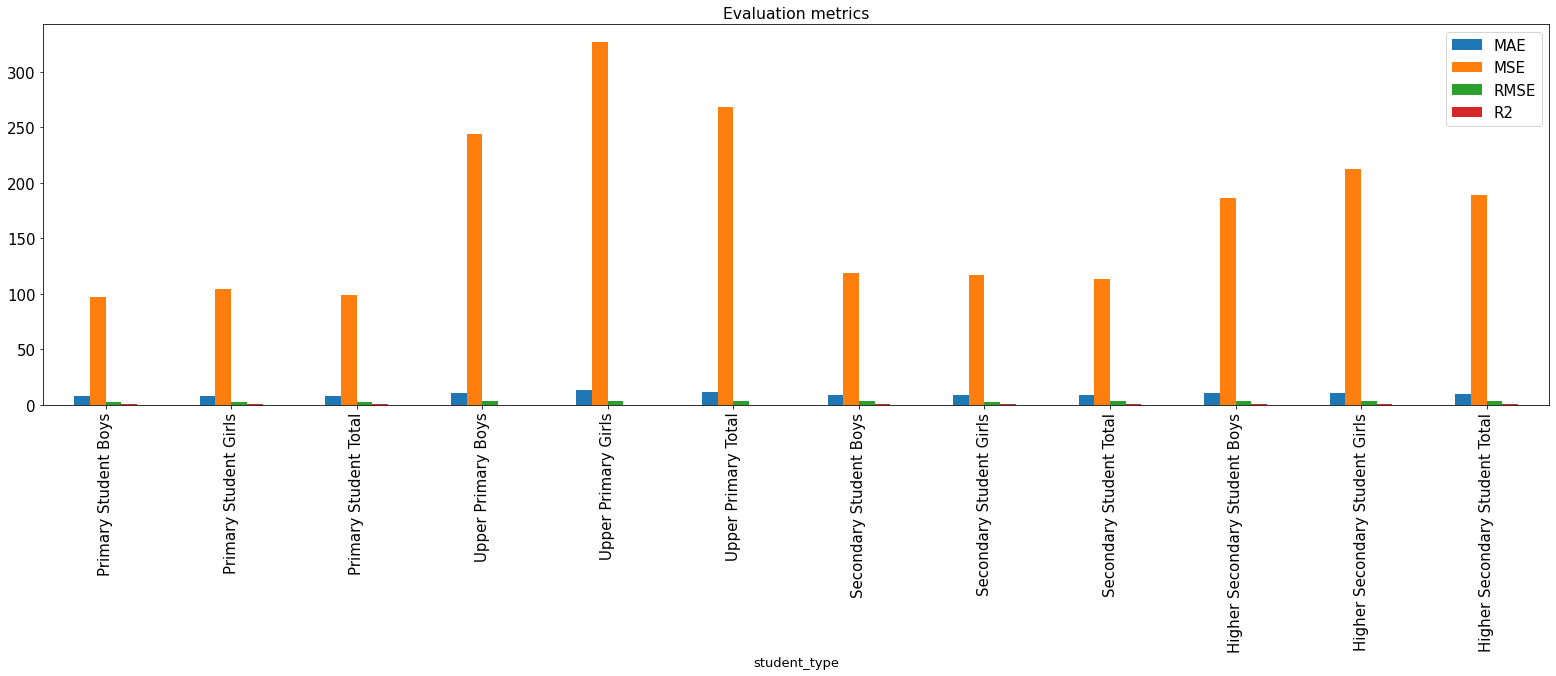

In [361]:
metric_df_rnd.plot(kind='bar', figsize=(27,7), title='Evaluation metrics')

## Using the XGBRegressor

In [363]:
def Model(train, target, test, algo=XGBRegressor):
    errcb1=[]
    y_pred_totcb1=[]
    fold=KFold(n_splits=9)
    i=1
    cols = train.columns.to_list()
    for train_index, test_index in fold.split(train,target):
        print(str(i) + ' iter')
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        m1 = algo(random_state=2020,alpha=0.5)
        m1.fit(X_train, y_train)
        p1 = m1.predict(test)
        y_pred_totcb1.append(p1)
        
#         preds = m1.predict_proba(X_test)[:,1]
#         print('err: ', log_loss(y_test, preds))
#         errcb1.append(log_loss(y_test, preds))
#         p1 = m1.predict_proba(test)[:,1]
#         y_pred_totcb1.append(p1)
#         preds = m1.predict(X_test)
#         print('err: ', log_loss(y_test, preds))
#         errcb1.append(log_loss(y_test, preds))
       
        
        best_feature = cols[np.argmax(m1.feature_importances_)]
        worst_feature = cols[np.argmin(m1.feature_importances_)]    
        print('Best Feature for the {} iteration is {}, while, the worst feature is {}'.format(i, best_feature, worst_feature))
        
        i+=1
    #np.mean(errcb1)
    return np.mean(y_pred_totcb1,axis=0)

In [364]:
metric_list_xgb = []                 ### Store the metric results of all Student category types

## Primary Student Category
### datasets are arranged as comp, elect, drop_out, boys, girls, water
### genders in target are arranged as boys, girls, both_gender

## Boys 

In [365]:
boy_pry_df = GenerateTrain(pry_useful,[0,1,2,3,5])
boy_eval_pry_df = GenerateTrain(eval_pry_useful,[0,1,2,3,5]) 
boy_primary_target = CreateTargetFeature(enrol_primary,0)    #0 for boys
eval_boy_primary_target = CreateTargetFeature(test_enrol_primary,0) 

In [366]:
DropNa(boy_pry_df,boy_primary_target)          # Run cell only once
DropNa(boy_eval_pry_df,eval_boy_primary_target)

In [367]:
boy_primary_target.shape, boy_pry_df.shape, boy_eval_pry_df.shape, eval_boy_primary_target.shape

((36,), (36, 15), (37, 15), (37,))

In [368]:
boy_pry_preds = Model(boy_pry_df, boy_primary_target, boy_eval_pry_df)

1 iter
Best Feature for the 1 iteration is drop_out_mean_Primary_Boys, while, the worst feature is boys_mean_Primary_with_U_Primary_Sec_HrSec
2 iter
Best Feature for the 2 iteration is drop_out_mean_Primary_Boys, while, the worst feature is boys_mean_Primary_with_U_Primary_Sec_HrSec
3 iter
Best Feature for the 3 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_Only
4 iter
Best Feature for the 4 iteration is water_mean_Primary_with_U_Primary, while, the worst feature is drop_out_mean_Primary_Total
5 iter
Best Feature for the 5 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_Only
6 iter
Best Feature for the 6 iteration is water_mean_Primary_with_U_Primary, while, the worst feature is drop_out_mean_Primary_Total
7 iter
Best Feature for the 7 iteration is water_mean_Primary_Only, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSec
8 iter
Best Feature for the 8 iteration is drop_out_mean_Prima

In [369]:
ModelEvaluator(eval_boy_primary_target, boy_pry_preds)

{'MAE': 7.437372288059544,
 'MSE': 97.09556577883353,
 'RMSE': 2.7271546138896388,
 'R2': 0.483747636518299}

In [370]:
metric_list_xgb.append(['Primary Student Boys',ModelEvaluator(eval_boy_primary_target, boy_pry_preds)])   # run only once

## Girls

In [371]:
girl_pry_df = GenerateTrain(pry_useful,[0,1,2,4,5])
girl_eval_pry_df = GenerateTrain(eval_pry_useful,[0,1,2,4,5]) 
girl_primary_target = CreateTargetFeature(enrol_primary,1)    #1 for girls
eval_girl_primary_target = CreateTargetFeature(test_enrol_primary, 1)

In [372]:
DropNa(girl_pry_df, girl_primary_target)   # Run  only once
DropNa(girl_eval_pry_df, eval_girl_primary_target)

In [373]:
girl_primary_target.shape, girl_pry_df.shape, girl_eval_pry_df.shape, eval_girl_primary_target.shape

((36,), (36, 15), (37, 15), (37,))

In [374]:
girl_pry_preds = Model(girl_pry_df, girl_primary_target, girl_eval_pry_df)

1 iter
Best Feature for the 1 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_with_U_Primary_Sec_HrSec
2 iter
Best Feature for the 2 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_with_U_Primary
3 iter
Best Feature for the 3 iteration is drop_out_mean_Primary_Boys, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec_HrSec
4 iter
Best Feature for the 4 iteration is water_mean_Primary_with_U_Primary, while, the worst feature is girls_mean_Primary_Only
5 iter
Best Feature for the 5 iteration is elect_mean_Primary_with_U_Primary, while, the worst feature is drop_out_mean_Primary_Total
6 iter
Best Feature for the 6 iteration is water_mean_Primary_with_U_Primary, while, the worst feature is drop_out_mean_Primary_Total
7 iter
Best Feature for the 7 iteration is water_mean_Primary_Only, while, the worst feature is water_mean_Primary_with_U_Primary
8 iter
Best Feature for the 8 iteration is water_mean

In [375]:
ModelEvaluator(eval_girl_primary_target, girl_pry_preds)

{'MAE': 7.786493084881758,
 'MSE': 105.98876504889071,
 'RMSE': 2.7904288353014413,
 'R2': 0.4533712447806605}

In [376]:
metric_list_xgb.append(['Primary Student Girls', ModelEvaluator(eval_girl_primary_target, girl_pry_preds) ])   # run only once

##  Total

In [377]:
total_pry_df = GenerateTrain(pry_useful,[0,1,2,3,4,5])
total_eval_pry_df = GenerateTrain(eval_pry_useful,[0,1,2,3,4,5]) 
total_primary_target = CreateTargetFeature(enrol_primary)    
total_eval_primary_target = CreateTargetFeature(test_enrol_primary) 

In [378]:
DropNa(total_pry_df,total_primary_target)          # Run cell only once
DropNa(total_eval_pry_df,total_eval_primary_target)

In [379]:
total_primary_target.shape, total_pry_df.shape, total_eval_pry_df.shape, total_eval_primary_target.shape

((36,), (36, 18), (37, 18), (37,))

In [380]:
total_pry_preds = Model(total_pry_df, total_primary_target, total_eval_pry_df)

1 iter
Best Feature for the 1 iteration is drop_out_mean_Primary_Boys, while, the worst feature is water_mean_Primary_with_U_Primary
2 iter
Best Feature for the 2 iteration is drop_out_mean_Primary_Boys, while, the worst feature is water_mean_Primary_with_U_Primary
3 iter
Best Feature for the 3 iteration is drop_out_mean_Primary_Boys, while, the worst feature is water_mean_Primary_with_U_Primary
4 iter
Best Feature for the 4 iteration is water_mean_Primary_with_U_Primary, while, the worst feature is drop_out_mean_Primary_Total
5 iter
Best Feature for the 5 iteration is drop_out_mean_Primary_Boys, while, the worst feature is drop_out_mean_Primary_Girls
6 iter
Best Feature for the 6 iteration is water_mean_Primary_with_U_Primary, while, the worst feature is drop_out_mean_Primary_Total
7 iter
Best Feature for the 7 iteration is drop_out_mean_Primary_Boys, while, the worst feature is elect_mean_Primary_with_U_Primary
8 iter
Best Feature for the 8 iteration is water_mean_Primary_Only, while

In [381]:
ModelEvaluator(total_eval_primary_target, total_pry_preds)

{'MAE': 7.340211585792335,
 'MSE': 100.1539007305671,
 'RMSE': 2.7092824854179263,
 'R2': 0.4669227540894446}

In [382]:
metric_list_xgb.append(['Primary Student Total', ModelEvaluator(total_eval_primary_target, total_pry_preds) ])   # run only once

## Upper Primary Student Category
### datasets are arranged as comp, elect, drop_out, boys, girls, water
### genders in target are arranged as boys, girls, both_gender

## Boys

In [383]:
boy_upp_df = GenerateTrain(upp_useful,[0,1,2,3,5,])
boy_eval_upp_df = GenerateTrain(eval_upp_useful,[0,1,2,3,5]) 
boy_upp_target = CreateTargetFeature(enrol_upper_primary,0)    #0 for boys
eval_boy_upp_target = CreateTargetFeature(test_enrol_upper_primary, 0)

In [384]:
DropNa(boy_upp_df, boy_upp_target)   # Run  only once
DropNa(boy_eval_upp_df, eval_boy_upp_target)

In [385]:
boy_upp_target.shape, boy_upp_df.shape, boy_eval_upp_df.shape, eval_boy_upp_target.shape

((36,), (36, 15), (37, 15), (37,))

In [386]:
boy_upp_preds = Model(boy_upp_df, boy_upp_target, boy_eval_upp_df)

1 iter
Best Feature for the 1 iteration is elect_mean_U_Primary_Only, while, the worst feature is water_mean_U_Primary_Only
2 iter
Best Feature for the 2 iteration is elect_mean_U_Primary_With_Sec_HrSec, while, the worst feature is drop_out_mean_Upper Primary_Total
3 iter
Best Feature for the 3 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is water_mean_U_Primary_Only
4 iter
Best Feature for the 4 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is drop_out_mean_Upper Primary_Girls
5 iter
Best Feature for the 5 iteration is elect_mean_U_Primary_With_Sec_HrSec, while, the worst feature is water_mean_U_Primary_With_Sec_HrSec
6 iter
Best Feature for the 6 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is drop_out_mean_Upper Primary_Total
7 iter
Best Feature for the 7 iteration is elect_mean_Primary_with_U_Primary_Sec, while, the worst feature is drop_out_mean_Upper Primary_Total
8 iter
Best Feature fo

In [387]:
ModelEvaluator(eval_boy_upp_target, boy_upp_preds)

{'MAE': 9.95129061312289,
 'MSE': 212.7873330143672,
 'RMSE': 3.1545666284171094,
 'R2': 0.286661185280327}

In [388]:
metric_list_xgb.append(['Upper Primary Boys',ModelEvaluator(eval_boy_upp_target, boy_upp_preds)])   # run only once 

## Girls

In [389]:
girl_upp_df = GenerateTrain(upp_useful,[0,1,2,4,5])
girl_eval_upp_df = GenerateTrain(eval_upp_useful,[0,1,2,4,5]) 
girl_upp_target = CreateTargetFeature(enrol_upper_primary,1)    #1 for girls
girl_eval_upp_target = CreateTargetFeature(test_enrol_upper_primary, 1)

In [390]:
DropNa(girl_upp_df, girl_upp_target)   # Run  only once
DropNa(girl_eval_upp_df, girl_eval_upp_target)

In [391]:
girl_upp_target.shape, girl_upp_df.shape, girl_eval_upp_df.shape, girl_eval_upp_target.shape

((36,), (36, 15), (37, 15), (37,))

In [392]:
girl_upp_preds = Model(girl_upp_df, girl_upp_target, girl_eval_upp_df)

1 iter
Best Feature for the 1 iteration is drop_out_mean_Upper Primary_Total, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec
2 iter
Best Feature for the 2 iteration is elect_mean_U_Primary_With_Sec_HrSec, while, the worst feature is drop_out_mean_Upper Primary_Total
3 iter
Best Feature for the 3 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is water_mean_U_Primary_With_Sec_HrSec
4 iter
Best Feature for the 4 iteration is drop_out_mean_Upper Primary_Boys, while, the worst feature is water_mean_U_Primary_Only
5 iter
Best Feature for the 5 iteration is girls_mean_U_Primary_Only, while, the worst feature is water_mean_U_Primary_Only
6 iter
Best Feature for the 6 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is drop_out_mean_Upper Primary_Total
7 iter
Best Feature for the 7 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is water_mean_U_Primary_With_Sec_HrSec
8 iter
Best Feature for

In [393]:
ModelEvaluator(girl_eval_upp_target, girl_upp_preds)

{'MAE': 11.312618738122888,
 'MSE': 268.7220822233592,
 'RMSE': 3.3634236631924455,
 'R2': 0.32589549809277485}

In [394]:
metric_list_xgb.append(['Upper Primary Girls', ModelEvaluator(girl_eval_upp_target, girl_upp_preds)])   #run only once

## Total

In [395]:
total_upp_df = GenerateTrain(upp_useful,[0,1,2,3,4,5])
total_eval_upp_df = GenerateTrain(eval_upp_useful,[0,1,2,3,4,5]) 
total_upper_primary_target = CreateTargetFeature(enrol_upper_primary)   
total_eval_upper_primary_target = CreateTargetFeature(test_enrol_upper_primary) 

In [396]:
DropNa(total_upp_df,total_upper_primary_target)          # Run cell only once
DropNa(total_eval_upp_df,total_eval_upper_primary_target)

In [397]:
total_upper_primary_target.shape, total_upp_df.shape, total_eval_upp_df.shape, total_eval_upper_primary_target.shape

((36,), (36, 18), (37, 18), (37,))

In [398]:
total_upp_preds = Model(total_upp_df, total_upper_primary_target, total_eval_upp_df)

1 iter
Best Feature for the 1 iteration is elect_mean_U_Primary_With_Sec_HrSec, while, the worst feature is drop_out_mean_Upper Primary_Total
2 iter
Best Feature for the 2 iteration is elect_mean_U_Primary_With_Sec_HrSec, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec
3 iter
Best Feature for the 3 iteration is water_mean_Primary_with_U_Primary_Sec, while, the worst feature is elect_mean_U_Primary_With_Sec_HrSec
4 iter
Best Feature for the 4 iteration is girls_mean_U_Primary_Only, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec
5 iter
Best Feature for the 5 iteration is girls_mean_U_Primary_Only, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec
6 iter
Best Feature for the 6 iteration is girls_mean_U_Primary_Only, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec
7 iter
Best Feature for the 7 iteration is elect_mean_Primary_with_U_Primary_Sec, while, the worst feature is girls_mean_Primary_with_U_Primary_Sec
8 iter
Bes

In [399]:
ModelEvaluator(total_eval_upper_primary_target, total_upp_preds)

{'MAE': 10.723674761797932,
 'MSE': 249.23749931407886,
 'RMSE': 3.2747022401735904,
 'R2': 0.2534493985130859}

In [400]:
metric_list_xgb.append(['Upper Primary Total', ModelEvaluator(total_eval_upper_primary_target, total_upp_preds)])   #run only once

## Secondary Student Category
### datasets are arranged as comp, elect, drop_out, boys, girls, water
### genders in target are arranged as boys, girls, both_gender

## Boys

In [401]:
boy_sec_df = GenerateTrain(sec_useful,[0,1,2,3,5])
boy_eval_sec_df = GenerateTrain(eval_sec_useful,[0,1,2,3,5]) 
boy_sec_target = CreateTargetFeature(enrol_secondary,0)    #0 for boys
boy_eval_sec_target = CreateTargetFeature(test_enrol_secondary, 0)

In [402]:
DropNa(boy_sec_df, boy_sec_target)   # Run  only once
DropNa(boy_eval_sec_df, boy_eval_sec_target)

In [403]:
boy_sec_target.shape, boy_sec_df.shape, boy_eval_sec_df.shape, boy_eval_sec_target.shape

((36,), (36, 15), (37, 15), (37,))

In [404]:
boy_sec_preds = Model(boy_sec_df, boy_sec_target, boy_eval_sec_df)

1 iter
Best Feature for the 1 iteration is boys_mean_Sec_Only, while, the worst feature is boys_mean_U_Primary_With_Sec
2 iter
Best Feature for the 2 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_Sec_with_HrSec.
3 iter
Best Feature for the 3 iteration is water_mean_Sec_with_HrSec., while, the worst feature is drop_out_mean_Secondary _Total
4 iter
Best Feature for the 4 iteration is water_mean_Sec_Only, while, the worst feature is water_mean_U_Primary_With_Sec
5 iter
Best Feature for the 5 iteration is elect_mean_Sec_Only, while, the worst feature is water_mean_Sec_with_HrSec.
6 iter
Best Feature for the 6 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_U_Primary_With_Sec
7 iter
Best Feature for the 7 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_Sec_with_HrSec.
8 iter
Best Feature for the 8 iteration is water_mean_Sec_Only, while, the worst feature is drop_out_mean_Secondary _Total
9 iter
Best Feature for the 9

In [405]:
ModelEvaluator(boy_eval_sec_target, boy_sec_preds)

{'MAE': 9.181016697239228,
 'MSE': 143.18881849814096,
 'RMSE': 3.0300192569089766,
 'R2': 0.1815596288455662}

In [406]:
metric_list_xgb.append(['Secondary Student Boys',ModelEvaluator(boy_eval_sec_target, boy_sec_preds)])   # run only once

## Girls

In [407]:
girl_sec_df = GenerateTrain(sec_useful,[0,1,2,4,5])
girl_eval_sec_df = GenerateTrain(eval_sec_useful,[0,1,2,4,5]) 
girl_sec_target = CreateTargetFeature(enrol_secondary,1)    #1 for girls
girl_eval_sec_target = CreateTargetFeature(test_enrol_secondary,1)

In [408]:
DropNa(girl_sec_df, girl_sec_target)   # Run  only once
DropNa(girl_eval_sec_df, girl_eval_sec_target)

In [409]:
girl_sec_target.shape, girl_sec_df.shape, girl_eval_sec_df.shape, girl_eval_sec_target.shape

((36,), (36, 15), (37, 15), (37,))

In [410]:
girl_sec_preds = Model(girl_sec_df, girl_sec_target, girl_eval_sec_df)

1 iter
Best Feature for the 1 iteration is water_mean_Sec_Only, while, the worst feature is drop_out_mean_Secondary _Total
2 iter
Best Feature for the 2 iteration is water_mean_Sec_Only, while, the worst feature is drop_out_mean_Secondary _Total
3 iter
Best Feature for the 3 iteration is water_mean_Sec_Only, while, the worst feature is drop_out_mean_Secondary _Total
4 iter
Best Feature for the 4 iteration is water_mean_Sec_Only, while, the worst feature is drop_out_mean_Secondary _Total
5 iter
Best Feature for the 5 iteration is water_mean_Sec_Only, while, the worst feature is drop_out_mean_Secondary _Total
6 iter
Best Feature for the 6 iteration is water_mean_Sec_Only, while, the worst feature is water_mean_Sec_with_HrSec.
7 iter
Best Feature for the 7 iteration is water_mean_Sec_Only, while, the worst feature is drop_out_mean_Secondary _Total
8 iter
Best Feature for the 8 iteration is water_mean_Sec_Only, while, the worst feature is drop_out_mean_Secondary _Total
9 iter
Best Feature 

In [411]:
ModelEvaluator(girl_eval_sec_target, girl_sec_preds)

{'MAE': 8.871742438239021,
 'MSE': 141.0345867627066,
 'RMSE': 2.9785470347535257,
 'R2': 0.2805041924337547}

In [412]:
metric_list_xgb.append(['Secondary Student Girls', ModelEvaluator(girl_eval_sec_target, girl_sec_preds)])   #run only once

## Total

In [413]:
total_sec_df = GenerateTrain(sec_useful,[0,1,2,3,4,5])
total_eval_sec_df = GenerateTrain(eval_sec_useful,[0,1,2,3,4,5]) 
total_secondary_target = CreateTargetFeature(enrol_secondary)    #0 for boys
total_eval_secondary_target = CreateTargetFeature(test_enrol_secondary) 

In [414]:
DropNa(total_sec_df,total_secondary_target)          # Run cell only once
DropNa(total_eval_sec_df,total_eval_secondary_target)

In [415]:
total_secondary_target.shape, total_sec_df.shape, total_eval_sec_df.shape, total_eval_secondary_target.shape

((36,), (36, 18), (37, 18), (37,))

In [416]:
total_sec_preds = Model(total_sec_df, total_secondary_target, total_eval_sec_df)

1 iter
Best Feature for the 1 iteration is water_mean_Sec_Only, while, the worst feature is boys_mean_U_Primary_With_Sec
2 iter
Best Feature for the 2 iteration is girls_mean_Sec_with_HrSec., while, the worst feature is elect_mean_Sec_Only
3 iter
Best Feature for the 3 iteration is water_mean_Sec_Only, while, the worst feature is drop_out_mean_Secondary _Total
4 iter
Best Feature for the 4 iteration is water_mean_Sec_Only, while, the worst feature is drop_out_mean_Secondary _Total
5 iter
Best Feature for the 5 iteration is elect_mean_Sec_Only, while, the worst feature is water_mean_Sec_Only
6 iter
Best Feature for the 6 iteration is water_mean_Sec_Only, while, the worst feature is drop_out_mean_Secondary _Total
7 iter
Best Feature for the 7 iteration is girls_mean_Sec_Only, while, the worst feature is elect_mean_U_Primary_With_Sec
8 iter
Best Feature for the 8 iteration is girls_mean_Sec_Only, while, the worst feature is girls_mean_U_Primary_With_Sec
9 iter
Best Feature for the 9 itera

In [417]:
ModelEvaluator(total_eval_secondary_target, total_sec_preds)

{'MAE': 8.65991271972656,
 'MSE': 116.84806055038236,
 'RMSE': 2.942772964352935,
 'R2': 0.3281031740249416}

In [418]:
metric_list_xgb.append(['Secondary Student Total',ModelEvaluator(total_eval_secondary_target, total_sec_preds)])   #run only once

## Higher Secondary Student Category
### datasets are arranged as comp, elect, drop_out, boys, girls, water
### genders in target are arranged as boys, girls, both_gender

## Boys

In [419]:
boy_high_df = GenerateTrain(high_useful,[0,1,2,3,5])
boy_eval_high_df = GenerateTrain(eval_high_useful,[0,1,2,3,5]) 
boy_high_target = CreateTargetFeature(enrol_higher,0)    #0 for boys
boy_eval_high_target = CreateTargetFeature(test_enrol_higher, 0)

In [420]:
DropNa(boy_high_df, boy_high_target)   # Run  only once
DropNa(boy_eval_high_df, boy_eval_high_target)

In [421]:
boy_high_target.shape, boy_high_df.shape, boy_eval_high_df.shape, boy_eval_high_target.shape

((36,), (36, 11), (37, 11), (37,))

In [422]:
boy_high_preds = Model(boy_high_df, boy_high_target, boy_eval_high_df)

1 iter
Best Feature for the 1 iteration is elect_mean_All Schools, while, the worst feature is water_mean_HrSec_Only
2 iter
Best Feature for the 2 iteration is drop_out_mean_HrSecondary_Total, while, the worst feature is drop_out_mean_HrSecondary_Boys
3 iter
Best Feature for the 3 iteration is elect_mean_All Schools, while, the worst feature is water_mean_HrSec_Only
4 iter
Best Feature for the 4 iteration is elect_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
5 iter
Best Feature for the 5 iteration is elect_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
6 iter
Best Feature for the 6 iteration is elect_mean_All Schools, while, the worst feature is elect_mean_HrSec_Only
7 iter
Best Feature for the 7 iteration is drop_out_mean_HrSecondary_Total, while, the worst feature is water_mean_HrSec_Only
8 iter
Best Feature for the 8 iteration is elect_mean_All Schools, while, the worst feature is water_mean_HrSec_Only
9 iter
Best Featu

In [423]:
ModelEvaluator(boy_eval_high_target, boy_high_preds)

{'MAE': 14.546281208347628,
 'MSE': 307.36849918492277,
 'RMSE': 3.8139587318621615,
 'R2': -0.11595582441018504}

In [424]:
metric_list_xgb.append(['Higher Secondary Student Boys', ModelEvaluator(boy_eval_high_target, boy_high_preds)])  # run only once

## Girls

In [425]:
girl_high_df = GenerateTrain(high_useful,[0,1,2,4,5])
girl_eval_high_df = GenerateTrain(eval_high_useful,[0,1,2,4,5]) 
girl_high_target = CreateTargetFeature(enrol_higher,1)    #1 for girls
girl_eval_high_target = CreateTargetFeature(test_enrol_higher,1)

In [426]:
DropNa(girl_high_df, girl_high_target)   # Run  only once
DropNa(girl_eval_high_df, girl_eval_high_target)

In [427]:
girl_high_target.shape, girl_high_df.shape, girl_eval_high_df.shape, girl_eval_high_target.shape

((36,), (36, 11), (37, 11), (37,))

In [428]:
girl_high_preds = Model(girl_high_df, girl_high_target, girl_eval_high_df)

1 iter
Best Feature for the 1 iteration is elect_mean_All Schools, while, the worst feature is comp_mean_HrSec_Only
2 iter
Best Feature for the 2 iteration is elect_mean_All Schools, while, the worst feature is water_mean_HrSec_Only
3 iter
Best Feature for the 3 iteration is elect_mean_All Schools, while, the worst feature is elect_mean_HrSec_Only
4 iter
Best Feature for the 4 iteration is comp_mean_All Schools, while, the worst feature is water_mean_HrSec_Only
5 iter
Best Feature for the 5 iteration is drop_out_mean_HrSecondary_Total, while, the worst feature is water_mean_HrSec_Only
6 iter
Best Feature for the 6 iteration is elect_mean_All Schools, while, the worst feature is elect_mean_HrSec_Only
7 iter
Best Feature for the 7 iteration is drop_out_mean_HrSecondary_Total, while, the worst feature is water_mean_HrSec_Only
8 iter
Best Feature for the 8 iteration is elect_mean_All Schools, while, the worst feature is water_mean_HrSec_Only
9 iter
Best Feature for the 9 iteration is drop_

In [429]:
ModelEvaluator(girl_eval_high_target, girl_high_preds)

{'MAE': 13.70607231964936,
 'MSE': 337.0281159103482,
 'RMSE': 3.7021712979884334,
 'R2': 0.016374778249037436}

In [430]:
metric_list_xgb.append(['Higher Secondary Student Girls', ModelEvaluator(girl_eval_high_target, girl_high_preds)])  # run only once

## Total

In [431]:
total_high_df = GenerateTrain(high_useful,[0,1,2,3,4,5])
total_eval_high_df = GenerateTrain(eval_high_useful,[0,1,2,3,4,5]) 
total_higher_target = CreateTargetFeature(enrol_higher)    
total_eval_higher_target = CreateTargetFeature(test_enrol_higher) 

In [432]:
DropNa(total_high_df,total_higher_target)          # Run cell only once
DropNa(total_eval_high_df,total_eval_higher_target)

In [433]:
total_higher_target.shape, total_high_df.shape, total_eval_high_df.shape, total_eval_higher_target.shape

((36,), (36, 13), (37, 13), (37,))

In [434]:
total_high_preds = Model(total_high_df, total_higher_target, total_eval_high_df)

1 iter
Best Feature for the 1 iteration is girls_mean_All Schools, while, the worst feature is water_mean_HrSec_Only
2 iter
Best Feature for the 2 iteration is elect_mean_All Schools, while, the worst feature is water_mean_HrSec_Only
3 iter
Best Feature for the 3 iteration is elect_mean_All Schools, while, the worst feature is girls_mean_HrSec_Only
4 iter
Best Feature for the 4 iteration is elect_mean_All Schools, while, the worst feature is girls_mean_HrSec_Only
5 iter
Best Feature for the 5 iteration is elect_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
6 iter
Best Feature for the 6 iteration is elect_mean_All Schools, while, the worst feature is drop_out_mean_HrSecondary_Total
7 iter
Best Feature for the 7 iteration is drop_out_mean_HrSecondary_Total, while, the worst feature is drop_out_mean_HrSecondary_Boys
8 iter
Best Feature for the 8 iteration is elect_mean_All Schools, while, the worst feature is girls_mean_HrSec_Only
9 iter
Best Feature for th

In [435]:
ModelEvaluator(total_eval_higher_target, total_high_preds)

{'MAE': 13.269355637833877,
 'MSE': 290.29680903446615,
 'RMSE': 3.6427126757176276,
 'R2': 0.03208249876769187}

In [436]:
metric_list_xgb.append(['Higher Secondary Student Total', ModelEvaluator(total_eval_higher_target, total_high_preds)])  # run only once

In [437]:
len(metric_list_xgb)   # should be 12

12

In [438]:
student_type = pd.Series( [i[0] for i in metric_list_rnd], name='student_type' )
MAE_metric = pd.Series( [i[1]['MAE'] for i in metric_list_rnd], name='MAE' )
MSE_metric = pd.Series( [i[1]['MSE'] for i in metric_list_rnd], name='MSE' )
RMSE_metric = pd.Series( [i[1]["RMSE"] for i in metric_list_rnd], name='RMSE' )
R2_metric = pd.Series( [i[1]['R2'] for i in metric_list_rnd], name='R2' )
metric_df_xgb = pd.DataFrame(pd.concat([student_type, MAE_metric, MSE_metric,RMSE_metric, R2_metric], axis=1)).set_index('student_type')

<AxesSubplot:title={'center':'Evaluation metrics'}, xlabel='student_type'>

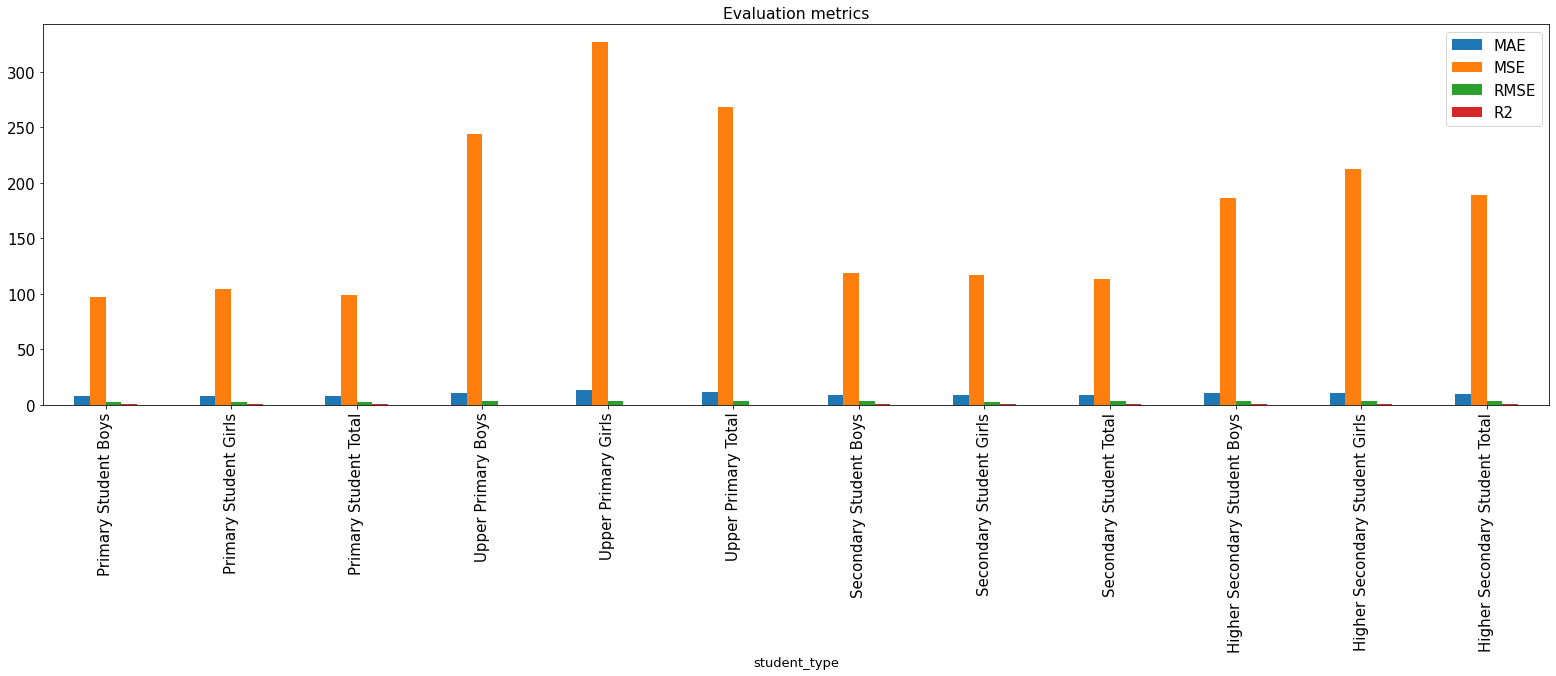

In [439]:
metric_df_xgb.plot(kind='bar', figsize=(27,7), title='Evaluation metrics')

## Using the ElasticNet 

In [440]:
def Model(train, target, test, algo=ElasticNet):
    errcb1=[]
    y_pred_totcb1=[]
    fold=KFold(n_splits=9)
    i=1
    cols = train.columns.to_list()
    for train_index, test_index in fold.split(train,target):
        print(str(i) + ' iter')
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        m1 = algo(random_state=2020)
        m1.fit(X_train, y_train)
        p1 = m1.predict(test)
        y_pred_totcb1.append(p1)
        
#         preds = m1.predict_proba(X_test)[:,1]
#         print('err: ', log_loss(y_test, preds))
#         errcb1.append(log_loss(y_test, preds))
#         p1 = m1.predict_proba(test)[:,1]
#         y_pred_totcb1.append(p1)
#         preds = m1.predict(X_test)
#         print('err: ', log_loss(y_test, preds))
#         errcb1.append(log_loss(y_test, preds))
       
        
#         best_feature = cols[np.argmax(m1.feature_importances_)]
#         worst_feature = cols[np.argmin(m1.feature_importances_)]    
#         print('Best Feature for the {} iteration is {}, while, the worst feature is {}'.format(i, best_feature, worst_feature))
        
        i+=1
    #np.mean(errcb1)
    return np.mean(y_pred_totcb1,axis=0)

In [441]:
metric_list_eln = []                 ### Store the metric results of all Student category types

## Primary Student Category
### datasets are arranged as comp, elect, drop_out, boys, girls, water
### genders in target are arranged as boys, girls, both_gender

## Boys 

In [442]:
boy_pry_df = GenerateTrain(pry_useful,[0,1,2,3,5])
boy_eval_pry_df = GenerateTrain(eval_pry_useful,[0,1,2,3,5]) 
boy_primary_target = CreateTargetFeature(enrol_primary,0)    #0 for boys
eval_boy_primary_target = CreateTargetFeature(test_enrol_primary,0) 

In [443]:
DropNa(boy_pry_df,boy_primary_target)          # Run cell only once
DropNa(boy_eval_pry_df,eval_boy_primary_target)

In [444]:
boy_primary_target.shape, boy_pry_df.shape, boy_eval_pry_df.shape, eval_boy_primary_target.shape

((36,), (36, 15), (37, 15), (37,))

In [445]:
boy_pry_preds = Model(boy_pry_df, boy_primary_target, boy_eval_pry_df)

1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter


In [446]:
ModelEvaluator(eval_boy_primary_target, boy_pry_preds)

{'MAE': 9.389917353807052,
 'MSE': 128.89401804937265,
 'RMSE': 3.06429720389636,
 'R2': 0.3146768246017314}

In [447]:
metric_list_eln.append(['Primary Student Boys',ModelEvaluator(eval_boy_primary_target, boy_pry_preds)])   # run only once

## Girls

In [448]:
girl_pry_df = GenerateTrain(pry_useful,[0,1,2,4,5])
girl_eval_pry_df = GenerateTrain(eval_pry_useful,[0,1,2,4,5]) 
girl_primary_target = CreateTargetFeature(enrol_primary,1)    #1 for girls
eval_girl_primary_target = CreateTargetFeature(test_enrol_primary, 1)

In [449]:
DropNa(girl_pry_df, girl_primary_target)   # Run  only once
DropNa(girl_eval_pry_df, eval_girl_primary_target)

In [450]:
girl_primary_target.shape, girl_pry_df.shape, girl_eval_pry_df.shape, eval_girl_primary_target.shape

((36,), (36, 15), (37, 15), (37,))

In [451]:
girl_pry_preds = Model(girl_pry_df, girl_primary_target, girl_eval_pry_df)

1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter


In [452]:
ModelEvaluator(eval_girl_primary_target, girl_pry_preds)

{'MAE': 9.37483205336475,
 'MSE': 144.38767303882005,
 'RMSE': 3.061834752785452,
 'R2': 0.2553318840367671}

In [453]:
metric_list_eln.append(['Primary Student Girls', ModelEvaluator(eval_girl_primary_target, girl_pry_preds) ])   # run only once

##  Total

In [454]:
total_pry_df = GenerateTrain(pry_useful,[0,1,2,3,4,5])
total_eval_pry_df = GenerateTrain(eval_pry_useful,[0,1,2,3,4,5]) 
total_primary_target = CreateTargetFeature(enrol_primary)    
total_eval_primary_target = CreateTargetFeature(test_enrol_primary) 

In [455]:
DropNa(total_pry_df,total_primary_target)          # Run cell only once
DropNa(total_eval_pry_df,total_eval_primary_target)

In [456]:
total_primary_target.shape, total_pry_df.shape, total_eval_pry_df.shape, total_eval_primary_target.shape

((36,), (36, 18), (37, 18), (37,))

In [457]:
total_pry_preds = Model(total_pry_df, total_primary_target, total_eval_pry_df)

1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter


In [458]:
ModelEvaluator(total_eval_primary_target, total_pry_preds)

{'MAE': 8.785157805455825,
 'MSE': 131.89073718198645,
 'RMSE': 2.9639766877382527,
 'R2': 0.298000872405081}

In [459]:
metric_list_eln.append(['Primary Student Total', ModelEvaluator(total_eval_primary_target, total_pry_preds) ])   # run only once

## Upper Primary Student Category
### datasets are arranged as comp, elect, drop_out, boys, girls, water
### genders in target are arranged as boys, girls, both_gender

## Boys

In [460]:
boy_upp_df = GenerateTrain(upp_useful,[0,1,2,3,5,])
boy_eval_upp_df = GenerateTrain(eval_upp_useful,[0,1,2,3,5]) 
boy_upp_target = CreateTargetFeature(enrol_upper_primary,0)    #0 for boys
eval_boy_upp_target = CreateTargetFeature(test_enrol_upper_primary, 0)

In [461]:
DropNa(boy_upp_df, boy_upp_target)   # Run  only once
DropNa(boy_eval_upp_df, eval_boy_upp_target)

In [462]:
boy_upp_target.shape, boy_upp_df.shape, boy_eval_upp_df.shape, eval_boy_upp_target.shape

((36,), (36, 15), (37, 15), (37,))

In [463]:
boy_upp_preds = Model(boy_upp_df, boy_upp_target, boy_eval_upp_df)

1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter


In [464]:
ModelEvaluator(eval_boy_upp_target, boy_upp_preds)

{'MAE': 10.868323765486252,
 'MSE': 208.1070360565348,
 'RMSE': 3.2967140860994077,
 'R2': 0.302351205156702}

In [465]:
metric_list_eln.append(['Upper Primary Boys',ModelEvaluator(eval_boy_upp_target, boy_upp_preds)])   # run only once 

## Girls

In [466]:
girl_upp_df = GenerateTrain(upp_useful,[0,1,2,4,5])
girl_eval_upp_df = GenerateTrain(eval_upp_useful,[0,1,2,4,5]) 
girl_upp_target = CreateTargetFeature(enrol_upper_primary,1)    #1 for girls
girl_eval_upp_target = CreateTargetFeature(test_enrol_upper_primary, 1)

In [467]:
DropNa(girl_upp_df, girl_upp_target)   # Run  only once
DropNa(girl_eval_upp_df, girl_eval_upp_target)

In [468]:
girl_upp_target.shape, girl_upp_df.shape, girl_eval_upp_df.shape, girl_eval_upp_target.shape

((36,), (36, 15), (37, 15), (37,))

In [469]:
girl_upp_preds = Model(girl_upp_df, girl_upp_target, girl_eval_upp_df)

1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter


In [470]:
ModelEvaluator(girl_eval_upp_target, girl_upp_preds)

{'MAE': 12.636827353032098,
 'MSE': 286.51088691370165,
 'RMSE': 3.5548315505846544,
 'R2': 0.28127127805811114}

In [471]:
metric_list_eln.append(['Upper Primary Girls', ModelEvaluator(girl_eval_upp_target, girl_upp_preds)])   #run only once

## Total

In [472]:
total_upp_df = GenerateTrain(upp_useful,[0,1,2,3,4,5])
total_eval_upp_df = GenerateTrain(eval_upp_useful,[0,1,2,3,4,5]) 
total_upper_primary_target = CreateTargetFeature(enrol_upper_primary)   
total_eval_upper_primary_target = CreateTargetFeature(test_enrol_upper_primary) 

In [473]:
DropNa(total_upp_df,total_upper_primary_target)          # Run cell only once
DropNa(total_eval_upp_df,total_eval_upper_primary_target)

In [474]:
total_upper_primary_target.shape, total_upp_df.shape, total_eval_upp_df.shape, total_eval_upper_primary_target.shape

((36,), (36, 18), (37, 18), (37,))

In [475]:
total_upp_preds = Model(total_upp_df, total_upper_primary_target, total_eval_upp_df)

1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter


In [476]:
ModelEvaluator(total_eval_upper_primary_target, total_upp_preds)

{'MAE': 12.024720676920795,
 'MSE': 235.21722368119308,
 'RMSE': 3.4676679017634884,
 'R2': 0.2954448656299876}

In [477]:
metric_list_eln.append(['Upper Primary Total', ModelEvaluator(total_eval_upper_primary_target, total_upp_preds)])   #run only once

## Secondary Student Category
### datasets are arranged as comp, elect, drop_out, boys, girls, water
### genders in target are arranged as boys, girls, both_gender

## Boys

In [478]:
boy_sec_df = GenerateTrain(sec_useful,[0,1,2,3,5])
boy_eval_sec_df = GenerateTrain(eval_sec_useful,[0,1,2,3,5]) 
boy_sec_target = CreateTargetFeature(enrol_secondary,0)    #0 for boys
boy_eval_sec_target = CreateTargetFeature(test_enrol_secondary, 0)

In [479]:
DropNa(boy_sec_df, boy_sec_target)   # Run  only once
DropNa(boy_eval_sec_df, boy_eval_sec_target)

In [480]:
boy_sec_target.shape, boy_sec_df.shape, boy_eval_sec_df.shape, boy_eval_sec_target.shape

((36,), (36, 15), (37, 15), (37,))

In [481]:
boy_sec_preds = Model(boy_sec_df, boy_sec_target, boy_eval_sec_df)

1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter


In [482]:
ModelEvaluator(boy_eval_sec_target, boy_sec_preds)

{'MAE': 10.72499572356038,
 'MSE': 194.0656224549485,
 'RMSE': 3.2749039258519295,
 'R2': -0.10924261919520206}

In [483]:
metric_list_eln.append(['Secondary Student Boys',ModelEvaluator(boy_eval_sec_target, boy_sec_preds)])   # run only once

## Girls

In [484]:
girl_sec_df = GenerateTrain(sec_useful,[0,1,2,4,5])
girl_eval_sec_df = GenerateTrain(eval_sec_useful,[0,1,2,4,5]) 
girl_sec_target = CreateTargetFeature(enrol_secondary,1)    #1 for girls
girl_eval_sec_target = CreateTargetFeature(test_enrol_secondary,1)

In [485]:
DropNa(girl_sec_df, girl_sec_target)   # Run  only once
DropNa(girl_eval_sec_df, girl_eval_sec_target)

In [486]:
girl_sec_target.shape, girl_sec_df.shape, girl_eval_sec_df.shape, girl_eval_sec_target.shape

((36,), (36, 15), (37, 15), (37,))

In [487]:
girl_sec_preds = Model(girl_sec_df, girl_sec_target, girl_eval_sec_df)

1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter


In [488]:
ModelEvaluator(girl_eval_sec_target, girl_sec_preds)

{'MAE': 9.519093670708566,
 'MSE': 150.44646820068348,
 'RMSE': 3.0853028491071286,
 'R2': 0.2324889545309511}

In [489]:
metric_list_eln.append(['Secondary Student Girls', ModelEvaluator(girl_eval_sec_target, girl_sec_preds)])   #run only once

## Total

In [490]:
total_sec_df = GenerateTrain(sec_useful,[0,1,2,3,4,5])
total_eval_sec_df = GenerateTrain(eval_sec_useful,[0,1,2,3,4,5]) 
total_secondary_target = CreateTargetFeature(enrol_secondary)    #0 for boys
total_eval_secondary_target = CreateTargetFeature(test_enrol_secondary) 

In [491]:
DropNa(total_sec_df,total_secondary_target)          # Run cell only once
DropNa(total_eval_sec_df,total_eval_secondary_target)

In [492]:
total_secondary_target.shape, total_sec_df.shape, total_eval_sec_df.shape, total_eval_secondary_target.shape

((36,), (36, 18), (37, 18), (37,))

In [493]:
total_sec_preds = Model(total_sec_df, total_secondary_target, total_eval_sec_df)

1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter


In [494]:
ModelEvaluator(total_eval_secondary_target, total_sec_preds)

{'MAE': 10.068746763289095,
 'MSE': 162.88159810386705,
 'RMSE': 3.173128860177143,
 'R2': 0.06340226564098284}

In [495]:
metric_list_eln.append(['Secondary Student Total',ModelEvaluator(total_eval_secondary_target, total_sec_preds)])   #run only once

## Higher Secondary Student Category
### datasets are arranged as comp, elect, drop_out, boys, girls, water
### genders in target are arranged as boys, girls, both_gender

## Boys

In [496]:
boy_high_df = GenerateTrain(high_useful,[0,1,2,3,5])
boy_eval_high_df = GenerateTrain(eval_high_useful,[0,1,2,3,5]) 
boy_high_target = CreateTargetFeature(enrol_higher,0)    #0 for boys
boy_eval_high_target = CreateTargetFeature(test_enrol_higher, 0)

In [497]:
DropNa(boy_high_df, boy_high_target)   # Run  only once
DropNa(boy_eval_high_df, boy_eval_high_target)

In [498]:
boy_high_target.shape, boy_high_df.shape, boy_eval_high_df.shape, boy_eval_high_target.shape

((36,), (36, 11), (37, 11), (37,))

In [499]:
boy_high_preds = Model(boy_high_df, boy_high_target, boy_eval_high_df)

1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter


In [500]:
ModelEvaluator(boy_eval_high_target, boy_high_preds)

{'MAE': 16.341548440281592,
 'MSE': 458.9342911722184,
 'RMSE': 4.042468112463176,
 'R2': -0.6662423007345029}

In [501]:
metric_list_eln.append(['Higher Secondary Student Boys', ModelEvaluator(boy_eval_high_target, boy_high_preds)])  # run only once

## Girls

In [502]:
girl_high_df = GenerateTrain(high_useful,[0,1,2,4,5])
girl_eval_high_df = GenerateTrain(eval_high_useful,[0,1,2,4,5]) 
girl_high_target = CreateTargetFeature(enrol_higher,1)    #1 for girls
girl_eval_high_target = CreateTargetFeature(test_enrol_higher,1)

In [503]:
DropNa(girl_high_df, girl_high_target)   # Run  only once
DropNa(girl_eval_high_df, girl_eval_high_target)

In [504]:
girl_high_target.shape, girl_high_df.shape, girl_eval_high_df.shape, girl_eval_high_target.shape

((36,), (36, 11), (37, 11), (37,))

In [505]:
girl_high_preds = Model(girl_high_df, girl_high_target, girl_eval_high_df)

1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter


In [506]:
ModelEvaluator(girl_eval_high_target, girl_high_preds)

{'MAE': 12.757535121296362,
 'MSE': 293.838690596989,
 'RMSE': 3.571769186453173,
 'R2': 0.14242422648691144}

In [507]:
metric_list_eln.append(['Higher Secondary Student Girls', ModelEvaluator(girl_eval_high_target, girl_high_preds)])  # run only once

## Total

In [508]:
total_high_df = GenerateTrain(high_useful,[0,1,2,3,4,5])
total_eval_high_df = GenerateTrain(eval_high_useful,[0,1,2,3,4,5]) 
total_higher_target = CreateTargetFeature(enrol_higher)    
total_eval_higher_target = CreateTargetFeature(test_enrol_higher) 

In [509]:
DropNa(total_high_df,total_higher_target)          # Run cell only once
DropNa(total_eval_high_df,total_eval_higher_target)

In [510]:
total_higher_target.shape, total_high_df.shape, total_eval_high_df.shape, total_eval_higher_target.shape

((36,), (36, 13), (37, 13), (37,))

In [511]:
total_high_preds = Model(total_high_df, total_higher_target, total_eval_high_df)

1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter


In [512]:
ModelEvaluator(total_eval_higher_target, total_high_preds)

{'MAE': 14.12732315514259,
 'MSE': 343.10277744726744,
 'RMSE': 3.758633149848837,
 'R2': -0.14398495841955694}

In [513]:
metric_list_eln.append(['Higher Secondary Student Total', ModelEvaluator(total_eval_higher_target, total_high_preds)])  # run only once

In [514]:
len(metric_list_xgb)   # should be 12

12

In [515]:
student_type = pd.Series( [i[0] for i in metric_list_rnd], name='student_type' )
MAE_metric = pd.Series( [i[1]['MAE'] for i in metric_list_rnd], name='MAE' )
MSE_metric = pd.Series( [i[1]['MSE'] for i in metric_list_rnd], name='MSE' )
RMSE_metric = pd.Series( [i[1]["RMSE"] for i in metric_list_rnd], name='RMSE' )
R2_metric = pd.Series( [i[1]['R2'] for i in metric_list_rnd], name='R2' )
metric_df_eln = pd.DataFrame(pd.concat([student_type, MAE_metric, MSE_metric,RMSE_metric, R2_metric], axis=1)).set_index('student_type')

<AxesSubplot:title={'center':'Evaluation metrics'}, xlabel='student_type'>

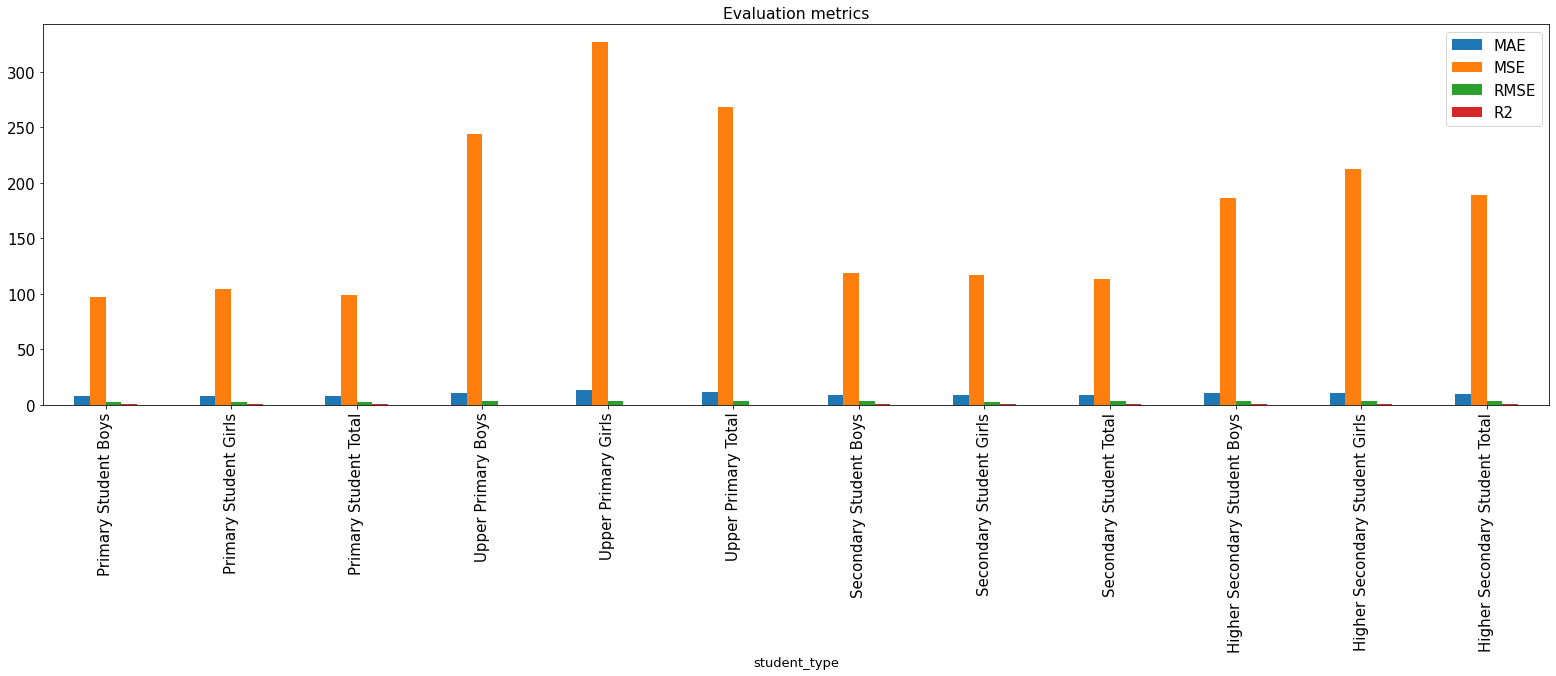

In [516]:
metric_df_eln.plot(kind='bar', figsize=(27,7), title='Evaluation metrics')

# So based on the  overall performance metrics the XGBoostRegressor so far is the best but based on the r2 score the ElasticNet is the best i also tested the Lasso and Ridge algorithms but they didn't perform as well as the two above.